<a href="https://colab.research.google.com/github/bmd94/Arabic-Sentiment-Analysis/blob/main/Arabic%20Sentiment%20Analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!wget "https://noto-website-2.storage.googleapis.com/pkgs/Noto-unhinted.zip"

--2021-04-20 23:18:01--  https://noto-website-2.storage.googleapis.com/pkgs/Noto-unhinted.zip
Resolving noto-website-2.storage.googleapis.com (noto-website-2.storage.googleapis.com)... 74.125.137.128, 2607:f8b0:4023:c06::80
Connecting to noto-website-2.storage.googleapis.com (noto-website-2.storage.googleapis.com)|74.125.137.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1114561068 (1.0G) [application/zip]
Saving to: ‘Noto-unhinted.zip’

Noto-unhinted.zip   100%[===================>]   1.04G  96.1MB/s    in 14s     

2021-04-20 23:18:15 (78.7 MB/s) - ‘Noto-unhinted.zip’ saved [1114561068/1114561068]



In [ ]:
!unzip "/content/Noto-unhinted.zip"

Archive:  /content/Noto-unhinted.zip
  inflating: LICENSE_OFL.txt         
  inflating: NotoColorEmoji.ttf      
  inflating: NotoEmoji-Regular.ttf   
  inflating: NotoKufiArabic-Bold.ttf  
  inflating: NotoKufiArabic-Regular.ttf  
  inflating: NotoMono-Regular.ttf    
  inflating: NotoNaskhArabic-Bold.ttf  
  inflating: NotoNaskhArabic-Regular.ttf  
  inflating: NotoNaskhArabicUI-Bold.ttf  
  inflating: NotoNaskhArabicUI-Regular.ttf  
  inflating: NotoNastaliqUrdu-Regular.ttf  
  inflating: NotoSans-Black.ttf      
  inflating: NotoSans-BlackItalic.ttf  
  inflating: NotoSans-Bold.ttf       
  inflating: NotoSans-BoldItalic.ttf  
  inflating: NotoSans-Condensed.ttf  
  inflating: NotoSans-CondensedBlack.ttf  
  inflating: NotoSans-CondensedBlackItalic.ttf  
  inflating: NotoSans-CondensedBold.ttf  
  inflating: NotoSans-CondensedBoldItalic.ttf  
  inflating: NotoSans-CondensedExtraBold.ttf  
  inflating: NotoSans-CondensedExtraBoldItalic.ttf  
  inflating: NotoSans-CondensedExtraLight

In [ ]:
!pip install arabic-reshaper

In [ ]:
!pip install python-bidi

In [ ]:
!pip install textblob

In [ ]:
!pip install xgboost

### Importing librairies 

In [ ]:
import re
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt 
import seaborn as sns
import string
import nltk
import warnings 
warnings.filterwarnings("ignore", category=DeprecationWarning)
from nltk.stem.isri import ISRIStemmer
from collections import Counter

from wordcloud import WordCloud          # pip install wordcloud
         
# -- Arabic text dependencies
from arabic_reshaper import reshape      # pip install arabic-reshaper
from bidi.algorithm import get_display   # pip install python-bidi
#from textblob_ar import TextBlob
import sklearn 
from sklearn import metrics
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import SGDClassifier
from sklearn.naive_bayes import MultinomialNB, BernoulliNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.pipeline import Pipeline
from sklearn.ensemble import AdaBoostClassifier, GradientBoostingClassifier
from xgboost import XGBClassifier
from sklearn.tree import DecisionTreeClassifier
import random

%matplotlib inline

### Load Data

In [ ]:
df_original = pd.read_excel('/content/drive/MyDrive/Data/tweeet vaccine.xlsx')

### Size

In [ ]:
df_original.shape

(34957, 6)

### Columns

In [ ]:
df_original.columns

Index(['tweetDate', 'handle', 'text', 'profileUrl', 'name', 'tweetLink'], dtype='object')

In [ ]:
df_original.dtypes

tweetDate     object
handle        object
text          object
profileUrl    object
name          object
tweetLink     object
dtype: object

### Shecking missing values

In [ ]:
# There is no missing values
df_original.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 34957 entries, 0 to 34956
Data columns (total 6 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   tweetDate   34957 non-null  object
 1   handle      34957 non-null  object
 2   text        34957 non-null  object
 3   profileUrl  34957 non-null  object
 4   name        34955 non-null  object
 5   tweetLink   34957 non-null  object
dtypes: object(6)
memory usage: 1.6+ MB


In [ ]:
df_original.head()

,tweetDate,handle,text,profileUrl,name,tweetLink
0,Sat Apr 03 22:09:32 +0000 2021,Madridista13_89,يقول :\nتخيلوا بكره يطلع خبر رسمي بأن \nفيه حظ...,https://twitter.com/Madridista13_89,؏لي الـــ أحمد RMA,https://twitter.com/Madridista13_89/status/137...
1,Sat Apr 03 21:48:23 +0000 2021,MAL_14199,تندمت اني اخذت اللقاح,https://twitter.com/MAL_14199,مروه,https://twitter.com/MAL_14199/status/137846442...
2,Sat Apr 03 21:48:55 +0000 2021,i__011,اخذت اللقاح الله ينفع به وللأمانه جهود تُشكر م...,https://twitter.com/i__011,ريان,https://twitter.com/i__011/status/137846455687...
3,Sat Apr 03 22:00:53 +0000 2021,AHebshi,@Ali__Assiri الاثار الجانبية محسومة تحتاج راحة...,https://twitter.com/AHebshi,iAlawi,https://twitter.com/AHebshi/status/13784675686...
4,Sat Apr 03 21:53:02 +0000 2021,afrah_bintsaif,@shaimarezk @Mohd_AlRais انا في مصر حاليا وال...,https://twitter.com/afrah_bintsaif,Afrah bint saif🇦🇪,https://twitter.com/afrah_bintsaif/status/1378...


# **1) Data Cleaning**

In [ ]:
# There is no duplicate lines
df_original.duplicated().sum()

0

In [ ]:
def remove_pattern(input_txt, pattern):
    r = re.findall(pattern, input_txt)
    for i in r:
        input_txt = re.sub(i, '', input_txt)
        
    return input_txt 

***Removing twitter handles (@user)***

In [ ]:
df_original['tidy_tweet'] = np.vectorize(remove_pattern)(df_original['text'], "@[\w]*")

***Removing links from tweets***

In [ ]:
df_original['tidy_tweet'] = np.vectorize(remove_pattern)(df_original['tidy_tweet'], "\w+:\/\/\S+")

***Removing special characters, numbers, punctuations***

In [ ]:
df_original['tidy_tweet'] = df_original['tidy_tweet'].str.replace("[^\u0621-\u064Aa-zA-Z#]+$", " ")

**Removing short words**

In [ ]:
df_original['tidy_tweet'] = df_original['tidy_tweet'].apply(lambda x: ' '.join([w for w in x.split() if len(w)>3]))

***Removing twitter handles (#hashtags)***

In [ ]:
#df_original['tidy_tweet'] = np.vectorize(remove_pattern)(df_original['tidy_tweet'], "#[\w]*")
df_original['tidy_tweet'] = np.vectorize(remove_pattern)(df_original['tidy_tweet'], "#")

***Removing twitter handles (emojies)***

In [ ]:
def remove_emojis(data):
    emoj = re.compile("["
        u"\U0001F600-\U0001F64F"  # emoticons
        u"\U0001F300-\U0001F5FF"  # symbols & pictographs
        u"\U0001F680-\U0001F6FF"  # transport & map symbols
        u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
        u"\U00002500-\U00002BEF"  # chinese char
        u"\U00002702-\U000027B0"
        u"\U00002702-\U000027B0"
        u"\U000024C2-\U0001F251"
        u"\U0001f926-\U0001f937"
        u"\U00010000-\U0010ffff"
        u"\u2640-\u2642" 
        u"\u2600-\u2B55"
        u"\u200d"
        u"\u23cf"
        u"\u23e9"
        u"\u231a"
        u"\ufe0f"  # dingbats
        u"\u3030"
                      "]+", re.UNICODE)
    return re.sub(emoj, '', data)

In [ ]:
df_original['tidy_tweet'] = df_original['tidy_tweet'].apply(lambda x: ' '.join([remove_emojis(w) for w in x.split()]))

In [ ]:
df_original['tidy_tweet'] = df_original['tidy_tweet'].str.replace("_", " ")

***Texte en grasText normalization***

In [ ]:
# Arabic light stemming for Arabic text
# takes a word list and perform light stemming for each Arabic words
stemmer = ISRIStemmer()
def light_stem(text):
    words = text.split()
    result = list()
    #stemmer = ISRIStemmer()
    for word in words:
        word = stemmer.norm(word, num=1)      # remove diacritics which representing Arabic short vowels
        if not word in stemmer.stop_words:    # exclude stop words from being processed
            word = stemmer.pre32(word)        # remove length three and length two prefixes in this order
            #word = stemmer.suf32(word)        # remove length three and length two suffixes in this order
            word = stemmer.waw(word)          # remove connective ‘و’ if it precedes a word beginning with ‘و’
            word = stemmer.norm(word, num=2)  # normalize initial hamza to bare alif
        result.append(word)
    return ' '.join(result)

if __name__ == '__main__':
    for i in range(len(df_original['tidy_tweet'])):
        try:
            df_original['tidy_tweet'][i] = light_stem(df_original['tidy_tweet'][i])
            print(df_original['tidy_tweet'][i])  
        except:
            print('error')

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Le flux de sortie a été tronqué et ne contient que les 5000 dernières lignes.
اخذت لقاح
اخذت لقاح اليوم واسطة غيره
سؤال متكرر لقاح اعزل نفسي لقاح جواب لانك اخذت بروتيني حمض يحفز مناعتك ويدربها تأخذ فيروس
فيها صحة عافية له..ياابا باسل بارحة اخذت لقاح موقع اخفيك سرا انبهرت مكان وحسن تنظيم تقنية عالية مستخدمة وفرة اعداد مقدمي خدمة محتاجين لقاح صراحة مايقدم مكان خدمات لطالبي لقاح كورونا لايمكن وصفه
اخذت لقاح زمان يتفقون خليج
حين مكام موضة اخذت لقاح بترجع تلبس كمام طبيعي
احيي دكتور هرفي شجاعه سواء لقاح يأخذه مسأله اولا واخيرا اقتناع اخذت لقاح انفلونزا مرتين حياتي.. مرة اولى ظهرت اعراض انفلونزا ثانيه تظهر ولله حمد اعتقد موضوع لايعدو كونه (فوبيا امراض
لاعب مثله مواطن سعودي يسجل موعد ويروح ياخذ لقاح سجلت موعد ورحت اخذت لقاح افضل تغريده اللي مامنها فايده نتائج تعصب رياضي
اخذت لقاح والا ورطت فيل ضعيف
حمد اخذت اليوم جرعه تطعيم لقاح كوفيد-١٩ شكر جزيل جهود التي بذلت توفير لقاح لأبناء عمان شكرا عمان غاليه
اهم يادكتور اخذت لقاح لأني ومثلي كثير يقتدون اطباء سعوديين
والله والله اخذت لقاح مطار ملك عبدال

In [ ]:
# print tweet after cleaning and normalization
df_original['tidy_tweet']

0        يقول تخيلوا بكره يطلع رسمي يبدأ رمضان وبيكون ه...
1                                          تندمت اخذت لقاح
2        اخذت لقاح الله ينفع امانه جهود تشكر اخذت دقيقه...
3        اثار جانبية محسومة تحتاج راحة يومين كثير ثلاثة...
4        حاليا مفروض اخذت لقاح عرفت عوده هناك عشره ايام...
                               ...                        
34952    اخبرني الله يسمح دخول جنة تلقيت كلتا جرعتين لق...
34953    الله يعافيك دكتور حمد تلقيت جرعة اولى لقاح مرك...
34954    تلقيت لقاح اليوم تنظيم رائع.. تعامل راقي وبنفس...
34955    تلقيت لقاح فسوف يشير وسيسمح دخول. يشير تحصل لق...
34956    يوم، تلقيت لقاح CovID-19. علماء باحثين الذين ع...
Name: tidy_tweet, Length: 34957, dtype: object

*Plot the most freq words in all tweets*

In [ ]:
# get the most freq words in tweets
all_words = ' '.join([text for text in df_original['tidy_tweet']])
freq = pd.Series(all_words.split()).value_counts()[:25]
#freq

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 65010 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:183: RuntimeWarning: Glyph 65010 missing from current font.
  font.set_text(s, 0, flags=flags)


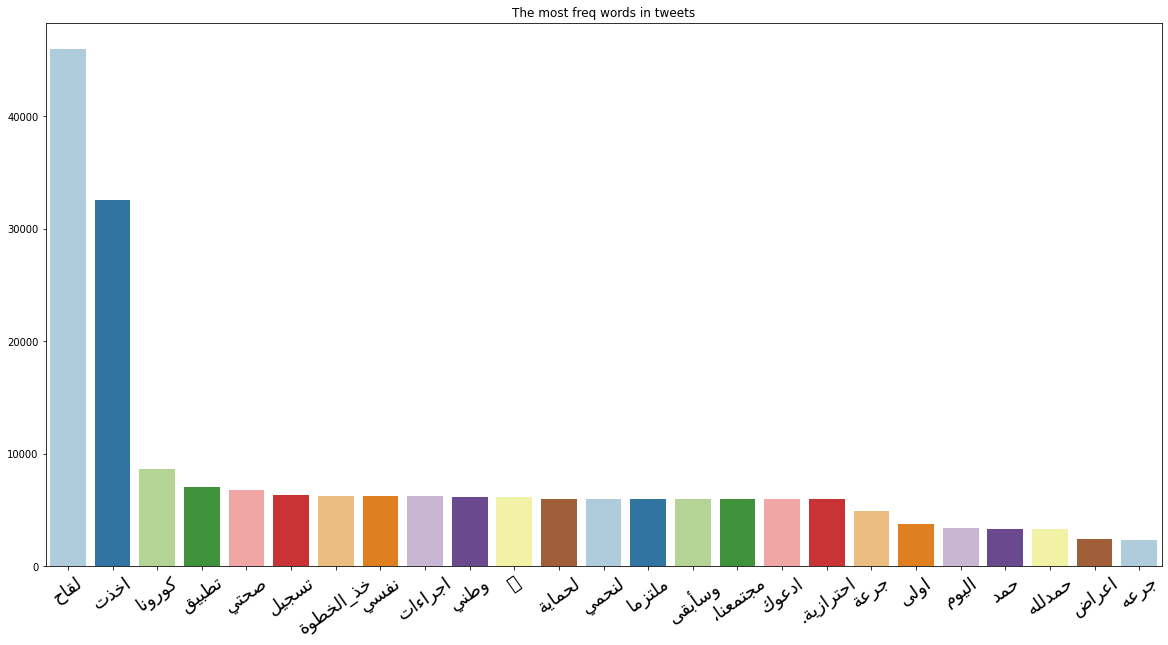

In [ ]:
import arabic_reshaper
combind = ' '.join(freq.index)
#combind
data = arabic_reshaper.reshape(combind)
data = get_display(data)
data = data.split()
data.reverse()
#print(data)
fig, ax = plt.subplots(figsize=(20,10))
ax = sns.barplot(data, freq.values, palette="Paired")


for tick in ax.xaxis.get_major_ticks():
                tick.label.set_fontsize(18)
                tick.label.set_rotation(35)
plt.savefig('term_frequency_all_data.png')
plt.title('The most freq words in tweets')
plt.show()

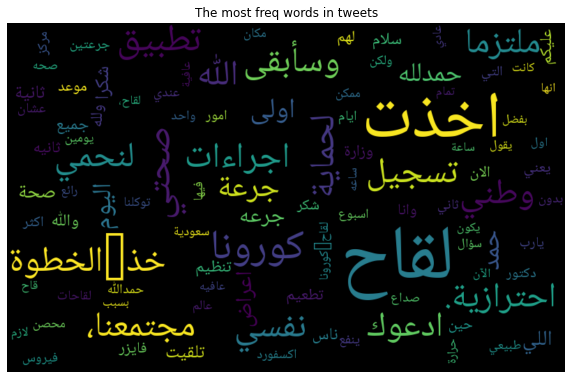

In [ ]:
rtl = lambda w: get_display(reshape(f'{w}')) #تعديل الاندر سكور

#all_words = ' '.join([text for text in merged['tidy_tweet']])
COUNTS = Counter(all_words.split())
counts = {rtl(k):v for k, v in COUNTS.most_common(100)}

font_file = '/content/NotoNaskhArabic-Regular.ttf' # download from: https://www.google.com/get/noto
wordcloud = WordCloud(font_path=font_file, width=800, height=500, random_state=21, max_font_size=110).generate_from_frequencies(counts)
plt.figure(figsize=(10, 7))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.title('The most freq words in tweets')
plt.show()



```
# It is obvious that 'تسجيل, صحتي, تطبيق,
كورونا, اخذت, لقاح' are the most common words in all tweets and that is normal in this time of the disaster
```



In [ ]:
from textblob import TextBlob

In [ ]:
# Create a function to get the subjectivity

def get_subjectivity(text):
  return TextBlob(text).sentiment.subjectivity

# Create a function to get the polarity

def get_polarity(text):
  return TextBlob(text).sentiment.polarity

# Create tow new columns 

df_original['subjectivity'] = df_original['tidy_tweet'].apply(get_subjectivity)
df_original['polarity'] = df_original['tidy_tweet'].apply(get_polarity)

In [ ]:
df_original.columns

Index(['tweetDate', 'handle', 'text', 'profileUrl', 'name', 'tweetLink',
       'tidy_tweet', 'subjectivity', 'polarity'],
      dtype='object')

In [ ]:
df_original.head(10)

,tweetDate,handle,text,profileUrl,name,tweetLink,tidy_tweet,subjectivity,polarity
0,Sat Apr 03 22:09:32 +0000 2021,Madridista13_89,يقول :\nتخيلوا بكره يطلع خبر رسمي بأن \nفيه حظ...,https://twitter.com/Madridista13_89,؏لي الـــ أحمد RMA,https://twitter.com/Madridista13_89/status/137...,يقول تخيلوا بكره يطلع رسمي يبدأ رمضان وبيكون ه...,0.0,0.0
1,Sat Apr 03 21:48:23 +0000 2021,MAL_14199,تندمت اني اخذت اللقاح,https://twitter.com/MAL_14199,مروه,https://twitter.com/MAL_14199/status/137846442...,تندمت اخذت لقاح,0.0,0.0
2,Sat Apr 03 21:48:55 +0000 2021,i__011,اخذت اللقاح الله ينفع به وللأمانه جهود تُشكر م...,https://twitter.com/i__011,ريان,https://twitter.com/i__011/status/137846455687...,اخذت لقاح الله ينفع امانه جهود تشكر اخذت دقيقه...,0.0,0.0
3,Sat Apr 03 22:00:53 +0000 2021,AHebshi,@Ali__Assiri الاثار الجانبية محسومة تحتاج راحة...,https://twitter.com/AHebshi,iAlawi,https://twitter.com/AHebshi/status/13784675686...,اثار جانبية محسومة تحتاج راحة يومين كثير ثلاثة...,0.0,0.0
4,Sat Apr 03 21:53:02 +0000 2021,afrah_bintsaif,@shaimarezk @Mohd_AlRais انا في مصر حاليا وال...,https://twitter.com/afrah_bintsaif,Afrah bint saif🇦🇪,https://twitter.com/afrah_bintsaif/status/1378...,حاليا مفروض اخذت لقاح عرفت عوده هناك عشره ايام...,0.0,0.0
5,Sat Apr 03 22:09:47 +0000 2021,Mutebx95,اخذت اللقاح وتورطت بديت اوسوس😂💔,https://twitter.com/Mutebx95,مُتعبّ ☭,https://twitter.com/Mutebx95/status/1378469805...,اخذت لقاح وتورطت بديت اوسوس,0.0,0.0
6,Sat Apr 03 21:56:47 +0000 2021,Peliigros,@Jxiiiii5 اخذت اللقاح وتعبت,https://twitter.com/Peliigros,‏غريق,https://twitter.com/Peliigros/status/137846653...,اخذت لقاح وتعبت,0.0,0.0
7,Sat Apr 03 22:10:22 +0000 2021,wade77z,@Dr_abdoty انت شاد حيلك فالدفاع عن اللقاح ودي ...,https://twitter.com/wade77z,الجفول,https://twitter.com/wade77z/status/13784699536...,حيلك فالدفاع لقاح اعرف اخذت لقاح يالصفي والا باقي,0.0,0.0
8,Sat Apr 03 21:58:15 +0000 2021,ahmed_ali_ad,@Maram22mary اخذت لقاح استرازينيكا اول 24 ساعه...,https://twitter.com/ahmed_ali_ad,AhMeD_DekO 🇮🇶#Baghdad,https://twitter.com/ahmed_ali_ad/status/137846...,اخذت لقاح استرازينيكا ساعه يبدأ عندك اعراض تشب...,0.0,0.0
9,Sat Apr 03 22:01:00 +0000 2021,lunapanda_12,جبر الخواطر على الله 🤍🌿 وذا الي مطمني,https://twitter.com/lunapanda_12,"𝑷𝑨𝑵𝑫𝑨 ✌︎ ""اخذت اللقاح""",https://twitter.com/lunapanda_12/status/137846...,خواطر الله مطمني,0.0,0.0


In [ ]:
df_original.subjectivity.value_counts()

0.000000    34836
1.000000       20
0.500000       13
0.333333       10
0.100000        7
0.300000        7
0.600000        4
0.666667        4
0.800000        4
0.600000        3
0.900000        3
0.550000        3
0.545455        2
0.650000        2
0.400000        2
0.250000        2
0.200000        2
0.833333        2
0.411869        1
0.888889        1
0.366667        1
0.150000        1
0.246667        1
0.335000        1
0.300000        1
0.613333        1
0.346667        1
0.260000        1
0.444444        1
0.560000        1
0.312500        1
0.357143        1
0.211111        1
0.483333        1
0.225000        1
0.428571        1
0.322222        1
0.437500        1
0.308333        1
0.447222        1
0.700000        1
0.416667        1
0.041667        1
0.288889        1
0.375000        1
0.593750        1
0.566071        1
0.450000        1
0.575000        1
Name: subjectivity, dtype: int64

In [ ]:
df_original.polarity.value_counts()

 0.000000    34849
 0.500000       16
 0.250000       14
 0.200000        5
 0.800000        4
-0.750000        4
 0.700000        4
 0.100000        3
 0.350000        3
 0.600000        3
 0.400000        3
 0.050000        3
 1.000000        3
 0.312500        2
-0.150000        2
 0.625000        2
-0.500000        2
 0.333333        2
 0.227273        2
-0.200000        2
-0.100000        2
 0.087273        1
 0.404167        1
 0.512500        1
 0.116667        1
 0.214286        1
-0.125000        1
 0.145000        1
-0.231818        1
 0.287500        1
 0.170000        1
 0.066667        1
 0.068182        1
 0.420000        1
 0.037500        1
 0.191667        1
 0.382143        1
 0.245455        1
 0.316667        1
 0.416667        1
-0.333333        1
 0.850000        1
 0.166667        1
 0.100000        1
-0.700000        1
 0.093750        1
 0.100000        1
 0.392500        1
Name: polarity, dtype: int64

In [ ]:
# Create a function to compute the Positive, Neutral, Negative analysis

def get_analysis(score):
  if score < 0 :
    return 'negative'
  elif score > 0 :
    return 'positive'
  else : return 'neutral'

In [ ]:
df_original['Sentiment'] = df_original['polarity'].apply(get_analysis)
df_original.head(10)

,tweetDate,handle,text,profileUrl,name,tweetLink,tidy_tweet,subjectivity,polarity,Sentiment
0,Sat Apr 03 22:09:32 +0000 2021,Madridista13_89,يقول :\nتخيلوا بكره يطلع خبر رسمي بأن \nفيه حظ...,https://twitter.com/Madridista13_89,؏لي الـــ أحمد RMA,https://twitter.com/Madridista13_89/status/137...,يقول تخيلوا بكره يطلع رسمي يبدأ رمضان وبيكون ه...,0.0,0.0,neutral
1,Sat Apr 03 21:48:23 +0000 2021,MAL_14199,تندمت اني اخذت اللقاح,https://twitter.com/MAL_14199,مروه,https://twitter.com/MAL_14199/status/137846442...,تندمت اخذت لقاح,0.0,0.0,neutral
2,Sat Apr 03 21:48:55 +0000 2021,i__011,اخذت اللقاح الله ينفع به وللأمانه جهود تُشكر م...,https://twitter.com/i__011,ريان,https://twitter.com/i__011/status/137846455687...,اخذت لقاح الله ينفع امانه جهود تشكر اخذت دقيقه...,0.0,0.0,neutral
3,Sat Apr 03 22:00:53 +0000 2021,AHebshi,@Ali__Assiri الاثار الجانبية محسومة تحتاج راحة...,https://twitter.com/AHebshi,iAlawi,https://twitter.com/AHebshi/status/13784675686...,اثار جانبية محسومة تحتاج راحة يومين كثير ثلاثة...,0.0,0.0,neutral
4,Sat Apr 03 21:53:02 +0000 2021,afrah_bintsaif,@shaimarezk @Mohd_AlRais انا في مصر حاليا وال...,https://twitter.com/afrah_bintsaif,Afrah bint saif🇦🇪,https://twitter.com/afrah_bintsaif/status/1378...,حاليا مفروض اخذت لقاح عرفت عوده هناك عشره ايام...,0.0,0.0,neutral
5,Sat Apr 03 22:09:47 +0000 2021,Mutebx95,اخذت اللقاح وتورطت بديت اوسوس😂💔,https://twitter.com/Mutebx95,مُتعبّ ☭,https://twitter.com/Mutebx95/status/1378469805...,اخذت لقاح وتورطت بديت اوسوس,0.0,0.0,neutral
6,Sat Apr 03 21:56:47 +0000 2021,Peliigros,@Jxiiiii5 اخذت اللقاح وتعبت,https://twitter.com/Peliigros,‏غريق,https://twitter.com/Peliigros/status/137846653...,اخذت لقاح وتعبت,0.0,0.0,neutral
7,Sat Apr 03 22:10:22 +0000 2021,wade77z,@Dr_abdoty انت شاد حيلك فالدفاع عن اللقاح ودي ...,https://twitter.com/wade77z,الجفول,https://twitter.com/wade77z/status/13784699536...,حيلك فالدفاع لقاح اعرف اخذت لقاح يالصفي والا باقي,0.0,0.0,neutral
8,Sat Apr 03 21:58:15 +0000 2021,ahmed_ali_ad,@Maram22mary اخذت لقاح استرازينيكا اول 24 ساعه...,https://twitter.com/ahmed_ali_ad,AhMeD_DekO 🇮🇶#Baghdad,https://twitter.com/ahmed_ali_ad/status/137846...,اخذت لقاح استرازينيكا ساعه يبدأ عندك اعراض تشب...,0.0,0.0,neutral
9,Sat Apr 03 22:01:00 +0000 2021,lunapanda_12,جبر الخواطر على الله 🤍🌿 وذا الي مطمني,https://twitter.com/lunapanda_12,"𝑷𝑨𝑵𝑫𝑨 ✌︎ ""اخذت اللقاح""",https://twitter.com/lunapanda_12/status/137846...,خواطر الله مطمني,0.0,0.0,neutral


In [ ]:
df_original.Sentiment.value_counts()

neutral     34849
positive       92
negative       16
Name: Sentiment, dtype: int64

In [ ]:
!pip install git+https://github.com/adhaamehab/textblob-ar.git

  Cloning https://github.com/adhaamehab/textblob-ar.git to /tmp/pip-req-build-upiljr06
  Running command git clone -q https://github.com/adhaamehab/textblob-ar.git /tmp/pip-req-build-upiljr06
  Created wheel for textblob-ar: filename=textblob_ar-0.0.2-py2.py3-none-any.whl size=4529459 sha256=0e72c1485d72fc2ecf324bfea7fdeab612bb2d696b8622a8718fc801cc34b3c4
  Stored in directory: /tmp/pip-ephem-wheel-cache-2qez8zw0/wheels/42/f1/a0/46da19b7f3753b129061371ecde05c40de5bc3b710f8ad7eeb
Successfully built textblob-ar


In [ ]:
from textblob_ar import TextBlob


In [ ]:
blob = TextBlob("هندسة البرمجيات هي دراسة تصميم وتنفيذ وتعديل البرمجيات بما يضمن توفر هذه البرمجيات بجودة عالية وتكلفة معقولة متاحة للجميع وقابلة للتطوير فيما بعد وسريعة للبناء. وهندسة البرمجيات تقوم على أسس ونظريات من الهندسة وعلوم الحاسب كمبدأ ال Functional Structure من الهندسة والذي يعتمد على مبدأ تصميم أجزاء صغيرة تتجانس في العمل مع بعضها لتشكل عمل الكل.")
blob.tokens

WordList(['هندسة', 'البرمجيات', 'هي', 'دراسة', 'تصميم', 'وتنفيذ', 'وتعديل', 'البرمجيات', 'بما', 'يضمن', 'توفر', 'هذه', 'البرمجيات', 'بجودة', 'عالية', 'وتكلفة', 'معقولة', 'متاحة', 'للجميع', 'وقابلة', 'للتطوير', 'فيما', 'بعد', 'وسريعة', 'للبناء', '.', 'وهندسة', 'البرمجيات', 'تقوم', 'على', 'أسس', 'ونظريات', 'من', 'الهندسة', 'وعلوم', 'الحاسب', 'كمبدأ', 'ال', 'Functional', 'Structure', 'من', 'الهندسة', 'والذي', 'يعتمد', 'على', 'مبدأ', 'تصميم', 'أجزاء', 'صغيرة', 'تتجانس', 'في', 'العمل', 'مع', 'بعضها', 'لتشكل', 'عمل', 'الكل', '.'])

# Upload corpus

In [ ]:
# instalation du package kaggle
!pip install -q kaggle

In [ ]:
# copier kaggle.json dans le dossier kaggle 
!cp '/content/drive/MyDrive/Kaggle/kaggle.json' ~/.kaggle/

In [ ]:
# donner les droits a kaggle.json
!chmod 600 ~/.kaggle/kaggle.json

In [ ]:
# Download corpus from kaggle 
!kaggle datasets download -d mksaad/arabic-sentiment-twitter-corpus

 30% 5.00M/16.9M [00:00<00:00, 41.6MB/s]
100% 16.9M/16.9M [00:00<00:00, 82.9MB/s]


In [ ]:
# Unzip corpus 
!unzip /content/arabic-sentiment-twitter-corpus.zip

Le flux de sortie a été tronqué et ne contient que les 5000 dernières lignes.
  inflating: arabic_tweets/pos/5501.txt  
  inflating: arabic_tweets/pos/5502.txt  
  inflating: arabic_tweets/pos/5503.txt  
  inflating: arabic_tweets/pos/5504.txt  
  inflating: arabic_tweets/pos/5505.txt  
  inflating: arabic_tweets/pos/5506.txt  
  inflating: arabic_tweets/pos/5507.txt  
  inflating: arabic_tweets/pos/5508.txt  
  inflating: arabic_tweets/pos/5509.txt  
  inflating: arabic_tweets/pos/551.txt  
  inflating: arabic_tweets/pos/5510.txt  
  inflating: arabic_tweets/pos/5511.txt  
  inflating: arabic_tweets/pos/5512.txt  
  inflating: arabic_tweets/pos/5513.txt  
  inflating: arabic_tweets/pos/5514.txt  
  inflating: arabic_tweets/pos/5515.txt  
  inflating: arabic_tweets/pos/5516.txt  
  inflating: arabic_tweets/pos/5517.txt  
  inflating: arabic_tweets/pos/5518.txt  
  inflating: arabic_tweets/pos/5519.txt  
  inflating: arabic_tweets/pos/552.txt  
  inflating: arabic_tweets/pos/5520.txt  


In [ ]:
ngrams = (1, 2, 3)
results = []
pos_training = '/content/drive/MyDrive/Data/train_Arabic_tweets_positive_20190413.tsv'
neg_training = '/content/drive/MyDrive/Data/train_Arabic_tweets_negative_20190413.tsv'

pos_testing = '/content/drive/MyDrive/Data/test_Arabic_tweets_positive_20190413.tsv'
neg_testing = '/content/drive/MyDrive/Data/test_Arabic_tweets_negative_20190413.tsv'

In [ ]:
def read_tsv(data_file):
    text_data = list()
    labels = list()
    infile = open(data_file, encoding='utf-8')
    for line in infile:
        if not line.strip():
            continue
        label, text = line.split('\t')
        text_data.append(text)
        labels.append(label)
    return text_data, labels

In [ ]:
def load(pos_train_file, neg_train_file, pos_test_file, neg_test_file):
    pos_train_data, pos_train_labels = read_tsv(pos_train_file)
    neg_train_data, neg_train_labels = read_tsv(neg_train_file)

    pos_test_data, pos_test_labels = read_tsv(pos_test_file)
    neg_test_data, neg_test_labels = read_tsv(neg_test_file)
    print('------------------------------------')

    sample_size = 5
    print('{} random train tweets (positive) .... '.format(sample_size))
    print(np.array(random.sample(pos_train_data, sample_size)))
    print('------------------------------------')
    print('{} random train tweets (negative) .... '.format(sample_size))
    print(np.array(random.sample(neg_train_data, sample_size)))
    print('------------------------------------')

    x_train = pos_train_data + neg_train_data
    y_train = pos_train_labels + neg_train_labels

    x_test = pos_test_data + neg_test_data
    y_test = pos_test_labels + neg_test_labels

    print('train data size:{}\ttest data size:{}'.format(len(y_train), len(y_test)))
    print('train data: # of pos:{}\t# of neg:{}\t'.format(y_train.count('pos'), y_train.count('neg')))
    print('test data: # of pos:{}\t# of neg:{}\t'.format(y_test.count('pos'), y_test.count('neg')))
    print('------------------------------------')
    return x_train, y_train, x_test, y_test



In [ ]:
classifiers = [AdaBoostClassifier(), GradientBoostingClassifier(), XGBClassifier(), MultinomialNB(),
               BernoulliNB(), SGDClassifier(), DecisionTreeClassifier(max_depth=5),
               RandomForestClassifier(max_depth=5, n_estimators=10, max_features=1),
               KNeighborsClassifier(3)
               ]
for g in ngrams:
    dataset = load(pos_training, neg_training, pos_testing, neg_testing)
    for alg in classifiers:
        alg_name = alg.__class__.__name__
        r = do_sa(g, alg, alg_name, dataset)
        results.append(r)

------------------------------------
5 random train tweets (positive) .... 
['أهلا وسهلا بحسابي الخامس عشر في تويتر ، صبرا لن استسلم على فعل انا مظلوم به 💕 وصباح الخيرات\n'
 'صورة لتبديل الشفت الصباحي والمسائي 😂\n'
 'ردة فعل لينا اختي لما صحت وشافت ميك اب امي وهي طالعه 😂\n'
 'الأشد مرارة ان يقتل القلب ممن كان يقاتل لأجلهم 😊\n'
 'يتنحى عشان يمسك الرئاسة 😂\n']
------------------------------------
5 random train tweets (negative) .... 
['انا تعبت يارب حقيقي تعبت من المعافرة 💔\n'
 '. . . عاهدتني بالوصل دوما طامعا كيف الجفا وأنت الذي عاهدتني 💔 . . .\n'
 'اكو حسابات عليها زحمة 😐\n' 'حزني المسلسل ياخي 😢\n'
 'نداوم عشان يشلنا الوادي 💔\n']
------------------------------------
train data size:47000	test data size:11751
train data: # of pos:23879	# of neg:23121	
test data: # of pos:5970	# of neg:5781	
------------------------------------
parameters
n grams: 1
classifier: AdaBoostClassifier
------------------------------------
              precision    recall  f1-score   support

         pos    

## Results Summary without cleaning corpus

In [ ]:
print('{0:25}{1:10}{2:10}{3:10}{4:10}'.format('algorithm', 'ngram', 'accuracy', 'precision', 'recall'))
print('---------------------------------------------------------------------')
for r in results:
    print('{0:25}{1:10}{2:10.3f}{3:10.3f}{4:10.3f}'.format(r[0], r[1], r[2], r[3], r[4]))

algorithm                ngram     accuracy  precision recall    
---------------------------------------------------------------------
AdaBoostClassifier                1     0.643     0.686     0.643
GradientBoostingClassifier         1     0.665     0.689     0.665
XGBClassifier                     1     0.654     0.695     0.654
MultinomialNB                     1     0.761     0.762     0.761
BernoulliNB                       1     0.758     0.763     0.758
SGDClassifier                     1     0.765     0.769     0.765
DecisionTreeClassifier            1     0.572     0.694     0.572
RandomForestClassifier            1     0.514     0.640     0.514
KNeighborsClassifier              1     0.698     0.748     0.698
AdaBoostClassifier                2     0.641     0.681     0.641
GradientBoostingClassifier         2     0.661     0.693     0.661
XGBClassifier                     2     0.660     0.705     0.660
MultinomialNB                     2     0.769     0.770     0.769
Bern

# Cleaning Corpus

In [ ]:
def load2(pos_train_file, neg_train_file, pos_test_file, neg_test_file):
    pos_train_data, pos_train_labels = read_tsv(pos_train_file)
    neg_train_data, neg_train_labels = read_tsv(neg_train_file)

    pos_test_data, pos_test_labels = read_tsv(pos_test_file)
    neg_test_data, neg_test_labels = read_tsv(neg_test_file)
   
    x_train = pos_train_data + neg_train_data
    y_train = pos_train_labels + neg_train_labels

    x_test = pos_test_data + neg_test_data
    y_test = pos_test_labels + neg_test_labels

    return x_train, y_train, x_test, y_test


x_train, y_train, x_test, y_test = load2(pos_training, neg_training, pos_testing, neg_testing)

In [ ]:
Cor_tr = pd.DataFrame()
Cor_tr['text_tr'], Cor_tr['label_tr'] = x_train, y_train
Cor_tr.head()

,text_tr,label_tr
0,نحن الذين يتحول كل ما نود أن نقوله إلى دعاء لل...,pos
1,وفي النهاية لن يبقىٰ معك آحدإلا من رأىٰ الجمال...,pos
2,من الخير نفسه 💛\n,pos
3,#زلزل_الملعب_نصرنا_بيلعب كن عالي الهمه ولا ترض...,pos
4,الشيء الوحيد الذي وصلوا فيه للعالمية هو : المس...,pos


In [ ]:
Cor_ts = pd.DataFrame()
Cor_ts['text_ts'], Cor_ts['label_ts'] = x_test, y_test
Cor_ts.head()

,text_ts,label_ts
0,#الهلال_الاهلي فوز هلالي مهم الحمد لله 💙 زوران...,pos
1,صباحك خيرات ومسرات 🌸\n,pos
2,#تأمل قال الله ﷻ :- _*​﴿بواد غير ذي زرع ﴾*_ 💫💫...,pos
3,😂😂 يا جدعان الرجاله اللي فوق ال دول خطر ع تويت...,pos
4,رساله صباحيه : 💛 اللهم اسألك التوفيق في جميع ا...,pos


In [ ]:
#Cor_ts['clean_tr'] = Cor_ts['text_tr']
Cor_tr['clean_tr'] = np.vectorize(remove_pattern)(Cor_tr['text_tr'], "@[\w]*")
Cor_tr['clean_tr'] = np.vectorize(remove_pattern)(Cor_tr['clean_tr'], "\w+:\/\/\S+")
Cor_tr['clean_tr'] = Cor_tr['clean_tr'].str.replace("[^\u0621-\u064Aa-zA-Z#]+$", " ")
Cor_tr['clean_tr'] = Cor_tr['clean_tr'].apply(lambda x: ' '.join([w for w in x.split() if len(w)>3]))
#df_original['tidy_tweet'] = np.vectorize(remove_pattern)(df_original['tidy_tweet'], "#[\w]*")
Cor_tr['clean_tr'] = np.vectorize(remove_pattern)(Cor_tr['clean_tr'], "#")
Cor_tr['clean_tr'] = np.vectorize(remove_pattern)(Cor_tr['clean_tr'], "_")
Cor_tr['clean_tr'] = Cor_tr['clean_tr'].str.replace("*", " ")
Cor_tr['clean_tr'] = Cor_tr['clean_tr'].apply(lambda x: ' '.join([remove_emojis(w) for w in x.split()]))

In [ ]:
Cor_tr['clean_tr']

0        الذين يتحول نقوله دعاء لله، تبحثوا فينا قوة، إ...
1        النهاية يبقىٰ آحدإلا رأىٰ الجمال روحك أماالمنب...
2                                               الخير نفسه
3        زلزلالملعبنصرنابيلعب عالي الهمه ترضى بغير القم...
4        الشيء الوحيد الذي وصلوا للعالمية المسيار كانوا...
                               ...                        
46995    أورانوس مكان القمر كوكب بعدا الشمس يبلغ قطره م...
46996                                          احسدك الايم
46997                                           لأول بنكون
46998                                            بقله واطي
46999    صبري النوى تركتني كئيبا غريبا باكيا متوجعا يام...
Name: clean_tr, Length: 47000, dtype: object

In [ ]:
Cor_ts['clean_ts'] = np.vectorize(remove_pattern)(Cor_ts['text_ts'], "@[\w]*")
Cor_ts['text_ts'] = np.vectorize(remove_pattern)(Cor_ts['text_ts'], "\w+:\/\/\S+")
Cor_ts['text_ts'] = Cor_ts['text_ts'].str.replace("[^\u0621-\u064Aa-zA-Z#]+$", " ")
Cor_ts['text_ts'] = Cor_ts['text_ts'].apply(lambda x: ' '.join([w for w in x.split() if len(w)>3]))
#df_original['tidy_tweet'] = np.vectorize(remove_pattern)(df_original['tidy_tweet'], "#[\w]*")
Cor_ts['text_ts'] = np.vectorize(remove_pattern)(Cor_ts['text_ts'], "#")
Cor_ts['text_ts'] = np.vectorize(remove_pattern)(Cor_ts['text_ts'], "_")
Cor_ts['text_ts'] = Cor_ts['text_ts'].str.replace("*", " ")
Cor_ts['text_ts'] = Cor_ts['text_ts'].apply(lambda x: ' '.join([remove_emojis(w) for w in x.split()]))

In [ ]:
Cor_ts['text_ts']

0        الهلالالاهلي هلالي الحمد زوران بيسلم المباراة ...
1                                       صباحك خيرات ومسرات
2        تأمل الله ​بواد ~ومع بالدعاء وارزقهم الثمرات م...
3        جدعان الرجاله اللي تويتر وربنا اسلوب يومين يدخ...
4        رساله صباحيه اللهم اسألك التوفيق جميع امورنا و...
                               ...                        
11746    النوم وانت مكسور احساس اللي قادر تنام لازم علش...
11747    استشهادالامامكاظمالغيظ السلام المعذب السجون وظ...
11748                                          الصحن بكبره
11749           قولوا تشوفوا ملاحظة التلطف لأنه المود عليه
11750    أردت تعرف شيئا إسالني تسأل غيري فعشاق التأليف ...
Name: text_ts, Length: 11751, dtype: object

In [ ]:
def do_sa2(n, my_classifier, name, X,Y,x,y):
    x_train, y_train, x_test, y_test = X,Y,x,y
    print('parameters')
    print('n grams:', n)
    print('classifier:', my_classifier.__class__.__name__)
    print('------------------------------------')

    pipeline = Pipeline([
        ('vect', TfidfVectorizer(min_df=0.0001, max_df=0.95,
                                 analyzer='word', lowercase=False,
                                 ngram_range=(1, n))),
        ('clf', my_classifier),
    ])

    pipeline.fit(x_train, y_train)
    feature_names = pipeline.named_steps['vect'].get_feature_names()

    y_predicted = pipeline.predict(x_test)

    # Print the classification report
    print(metrics.classification_report(y_test, y_predicted,
                                        target_names=['pos', 'neg']))

    # Print the confusion matrix
    cm = metrics.confusion_matrix(y_test, y_predicted)
    print(cm)
    print('# of features:', len(feature_names))
    print('sample of features:', random.sample(feature_names, 40))
    accuracy = accuracy_score(y_test, y_predicted)
    precision = precision_score(y_test, y_predicted, average='weighted')
    recall =  recall_score(y_test, y_predicted, average='weighted')
    return name, n, accuracy, precision, recall

In [ ]:
classifiers = [AdaBoostClassifier(), GradientBoostingClassifier(), XGBClassifier(), MultinomialNB(),
               BernoulliNB(), SGDClassifier(), DecisionTreeClassifier(max_depth=5),
               RandomForestClassifier(max_depth=5, n_estimators=10, max_features=1),
               KNeighborsClassifier(3)
               ]
for g in ngrams:
    #dataset = load(pos_training, neg_training, pos_testing, neg_testing)
    for alg in classifiers:
        alg_name = alg.__class__.__name__
        r = do_sa2(g, alg, alg_name, Cor_tr['text_tr'], Cor_tr['label_tr'], Cor_ts['text_ts'], Cor_ts['label_ts'])
        results.append(r)

parameters
n grams: 1
classifier: AdaBoostClassifier
------------------------------------
              precision    recall  f1-score   support

         pos       0.58      0.86      0.69      5781
         neg       0.74      0.40      0.52      5970

    accuracy                           0.62     11751
   macro avg       0.66      0.63      0.61     11751
weighted avg       0.66      0.62      0.60     11751

[[4955  826]
 [3588 2382]]
# of features: 13795
sample of features: ['علامه', 'تعطينا', 'تسجدين', 'يؤثر', 'كويس', 'زرقاء', 'سقما', 'الإمارات', 'أد', 'بصداقتهم', 'تكميم', 'قاسية', 'اوكي', 'سيد', 'العقول', 'يجتمع', 'اعرفهم', 'وأساهر', 'الطريقة', 'الاحد', 'حطوه', 'رحمه', 'العباد', 'أبتسامتي', 'فريقنا', 'اللوك', 'طيبة', 'تقل', 'وكيف', 'الاخوان', 'يتذكر', 'لب', 'بالى', 'الدولي', 'الابيض', 'غيابات', 'ومرة', 'بلغت', 'وانت', 'يااخ']
parameters
n grams: 1
classifier: GradientBoostingClassifier
------------------------------------
              precision    recall  f1-score   support

 

## Results Summary

In [ ]:
print('{0:25}{1:10}{2:10}{3:10}{4:10}'.format('algorithm', 'ngram', 'accuracy', 'precision', 'recall'))
print('---------------------------------------------------------------------')
for r in results:
    print('{0:25}{1:10}{2:10.3f}{3:10.3f}{4:10.3f}'.format(r[0], r[1], r[2], r[3], r[4]))

algorithm                ngram     accuracy  precision recall    
---------------------------------------------------------------------
AdaBoostClassifier                1     0.624     0.663     0.624
GradientBoostingClassifier         1     0.631     0.666     0.631
XGBClassifier                     1     0.629     0.673     0.629
MultinomialNB                     1     0.738     0.739     0.738
BernoulliNB                       1     0.749     0.757     0.749
SGDClassifier                     1     0.753     0.760     0.753
DecisionTreeClassifier            1     0.560     0.676     0.560
RandomForestClassifier            1     0.512     0.623     0.512
KNeighborsClassifier              1     0.694     0.739     0.694
AdaBoostClassifier                2     0.620     0.658     0.620
GradientBoostingClassifier         2     0.632     0.665     0.632
XGBClassifier                     2     0.623     0.674     0.623
MultinomialNB                     2     0.746     0.747     0.746
Bern



```
SGDClassifier is the best model to predict sentiment                     
```



In [ ]:
pipeline = Pipeline([
        ('vect', TfidfVectorizer(min_df=0.0001, max_df=0.95,
                                 analyzer='word', lowercase=False,
                                 ngram_range=(1, 3))),
        ('clf', SGDClassifier()),
    ])

pipeline.fit(Cor_tr['text_tr'], Cor_tr['label_tr'])
feature_names = pipeline.named_steps['vect'].get_feature_names()

y_predicted = pipeline.predict(df_original['tidy_tweet'])
df_original['new_sent'] = y_predicted
df_original

,tweetDate,handle,text,profileUrl,name,tweetLink,tidy_tweet,subjectivity,polarity,Sentiment,new_sent
0,Sat Apr 03 22:09:32 +0000 2021,Madridista13_89,يقول :\nتخيلوا بكره يطلع خبر رسمي بأن \nفيه حظ...,https://twitter.com/Madridista13_89,؏لي الـــ أحمد RMA,https://twitter.com/Madridista13_89/status/137...,يقول تخيلوا بكره يطلع رسمي يبدأ رمضان وبيكون ه...,0.0,0.0,neutral,neg
1,Sat Apr 03 21:48:23 +0000 2021,MAL_14199,تندمت اني اخذت اللقاح,https://twitter.com/MAL_14199,مروه,https://twitter.com/MAL_14199/status/137846442...,تندمت اخذت لقاح,0.0,0.0,neutral,neg
2,Sat Apr 03 21:48:55 +0000 2021,i__011,اخذت اللقاح الله ينفع به وللأمانه جهود تُشكر م...,https://twitter.com/i__011,ريان,https://twitter.com/i__011/status/137846455687...,اخذت لقاح الله ينفع امانه جهود تشكر اخذت دقيقه...,0.0,0.0,neutral,neg
3,Sat Apr 03 22:00:53 +0000 2021,AHebshi,@Ali__Assiri الاثار الجانبية محسومة تحتاج راحة...,https://twitter.com/AHebshi,iAlawi,https://twitter.com/AHebshi/status/13784675686...,اثار جانبية محسومة تحتاج راحة يومين كثير ثلاثة...,0.0,0.0,neutral,neg
4,Sat Apr 03 21:53:02 +0000 2021,afrah_bintsaif,@shaimarezk @Mohd_AlRais انا في مصر حاليا وال...,https://twitter.com/afrah_bintsaif,Afrah bint saif🇦🇪,https://twitter.com/afrah_bintsaif/status/1378...,حاليا مفروض اخذت لقاح عرفت عوده هناك عشره ايام...,0.0,0.0,neutral,neg
...,...,...,...,...,...,...,...,...,...,...,...
34952,Fri Dec 04 09:43:20 +0000 2020,miskalakhbar,3️⃣ لقد أخبرني الله أنه لن يسمح لك بالدخول إلى...,https://twitter.com/miskalakhbar,مسك,https://twitter.com/miskalakhbar/status/133479...,اخبرني الله يسمح دخول جنة تلقيت كلتا جرعتين لق...,0.0,0.0,neutral,neg
34953,Wed Dec 16 16:19:07 +0000 2020,Adnan3k,@BDFPhysician الله يعافيك دكتور الحمد لله تلقي...,https://twitter.com/Adnan3k,Adnan Al-Qallaf,https://twitter.com/Adnan3k/status/13392436698...,الله يعافيك دكتور حمد تلقيت جرعة اولى لقاح مرك...,0.0,0.0,neutral,pos
34954,Fri Dec 25 18:23:43 +0000 2020,Nk385,تلقيت اللقاح اليوم\nالتنظيم رائع.. التعامل راق...,https://twitter.com/Nk385,"د.ناجي علي الخليف MD, FACC, FRCPC",https://twitter.com/Nk385/status/1342536518775...,تلقيت لقاح اليوم تنظيم رائع.. تعامل راقي وبنفس...,0.0,0.0,neutral,neg
34955,Fri Jul 24 13:21:30 +0000 2020,NedaaAlkhamis,6. إذا كنت قد تلقيت اللقاح ، فسوف يشير إلى ذلك...,https://twitter.com/NedaaAlkhamis,د. نداء الخميس,https://twitter.com/NedaaAlkhamis/status/12866...,تلقيت لقاح فسوف يشير وسيسمح دخول. يشير تحصل لق...,0.0,0.0,neutral,neg


In [ ]:
#neg = ['ما ابغى' , 'اكره' , 'اخاف' , 'كريه' , 'موجع' , 'مؤلم' , 'ضدنا' , 'اثار جانبية' , 'غصب' , 'مغصوب' , 'اندم' ,  'للاسف' ,  'لا اريد',
#       'ندم', 'تندمت' , 'مؤامرة' , 'غير مفيد','ضار' , 'غير فعال' , 'غير مجدي']
pos = ['خفيف', 'مناعة','حياة', 'سعيد', 'مرتاح','متحمس' ,'حصانة','محصن','محصنة', 'الحمد', 'جيدة', 'تمام','رائع','طيبه']

#df[df['A'].str.contains("hello")]
#for w in neg:
#  df_original.loc[df_original.text.str.contains(w), 'new_sent'] = 'neg'
for w in pos:
  df_original.loc[df_original.text.str.contains(w), 'new_sent'] = 'pos'

neg    27665
pos     7292

In [ ]:
df_original.new_sent.value_counts()

neg    23337
pos    11620
Name: new_sent, dtype: int64

In [ ]:
# Save DataFrame as exel
#df_clean.to_csv('/content/drive/MyDrive/Data/swar.csv',index=False)
df_original.to_excel('/content/drive/MyDrive/Data/swar.xlsx',index=False)

# Load Data

In [ ]:
# Load exel file
df_original = pd.read_excel('/content/drive/MyDrive/Data/swar.xlsx')

In [ ]:
df_original

,tweetDate,handle,text,profileUrl,name,tweetLink,tidy_tweet,subjectivity,polarity,Sentiment,new_sent
0,Sat Apr 03 22:09:32 +0000 2021,Madridista13_89,يقول :\nتخيلوا بكره يطلع خبر رسمي بأن \nفيه حظ...,https://twitter.com/Madridista13_89,؏لي الـــ أحمد RMA,https://twitter.com/Madridista13_89/status/137...,يقول تخيلوا بكره يطلع رسمي يبدأ رمضان وبيكون ه...,0.0,0.0,neutral,neg
1,Sat Apr 03 21:48:23 +0000 2021,MAL_14199,تندمت اني اخذت اللقاح,https://twitter.com/MAL_14199,مروه,https://twitter.com/MAL_14199/status/137846442...,تندمت اخذت لقاح,0.0,0.0,neutral,neg
2,Sat Apr 03 21:48:55 +0000 2021,i__011,اخذت اللقاح الله ينفع به وللأمانه جهود تُشكر م...,https://twitter.com/i__011,ريان,https://twitter.com/i__011/status/137846455687...,اخذت لقاح الله ينفع امانه جهود تشكر اخذت دقيقه...,0.0,0.0,neutral,neg
3,Sat Apr 03 22:00:53 +0000 2021,AHebshi,@Ali__Assiri الاثار الجانبية محسومة تحتاج راحة...,https://twitter.com/AHebshi,iAlawi,https://twitter.com/AHebshi/status/13784675686...,اثار جانبية محسومة تحتاج راحة يومين كثير ثلاثة...,0.0,0.0,neutral,neg
4,Sat Apr 03 21:53:02 +0000 2021,afrah_bintsaif,@shaimarezk @Mohd_AlRais انا في مصر حاليا وال...,https://twitter.com/afrah_bintsaif,Afrah bint saif🇦🇪,https://twitter.com/afrah_bintsaif/status/1378...,حاليا مفروض اخذت لقاح عرفت عوده هناك عشره ايام...,0.0,0.0,neutral,neg
...,...,...,...,...,...,...,...,...,...,...,...
34952,Fri Dec 04 09:43:20 +0000 2020,miskalakhbar,3️⃣ لقد أخبرني الله أنه لن يسمح لك بالدخول إلى...,https://twitter.com/miskalakhbar,مسك,https://twitter.com/miskalakhbar/status/133479...,اخبرني الله يسمح دخول جنة تلقيت كلتا جرعتين لق...,0.0,0.0,neutral,neg
34953,Wed Dec 16 16:19:07 +0000 2020,Adnan3k,@BDFPhysician الله يعافيك دكتور الحمد لله تلقي...,https://twitter.com/Adnan3k,Adnan Al-Qallaf,https://twitter.com/Adnan3k/status/13392436698...,الله يعافيك دكتور حمد تلقيت جرعة اولى لقاح مرك...,0.0,0.0,neutral,pos
34954,Fri Dec 25 18:23:43 +0000 2020,Nk385,تلقيت اللقاح اليوم\nالتنظيم رائع.. التعامل راق...,https://twitter.com/Nk385,"د.ناجي علي الخليف MD, FACC, FRCPC",https://twitter.com/Nk385/status/1342536518775...,تلقيت لقاح اليوم تنظيم رائع.. تعامل راقي وبنفس...,0.0,0.0,neutral,pos
34955,Fri Jul 24 13:21:30 +0000 2020,NedaaAlkhamis,6. إذا كنت قد تلقيت اللقاح ، فسوف يشير إلى ذلك...,https://twitter.com/NedaaAlkhamis,د. نداء الخميس,https://twitter.com/NedaaAlkhamis/status/12866...,تلقيت لقاح فسوف يشير وسيسمح دخول. يشير تحصل لق...,0.0,0.0,neutral,neg


# Plot charts

# Question (1

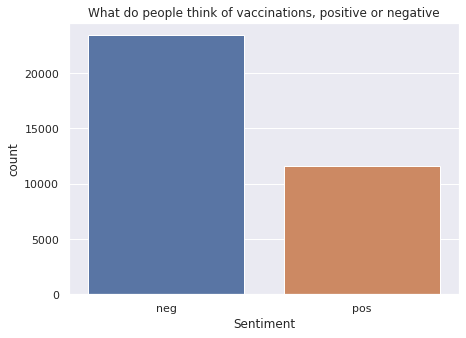

In [ ]:
plt.figure(figsize=(7,5))
sns.set_theme(style="darkgrid")
ax = sns.countplot(x="new_sent", data=df_original).set_title("What do people think of vaccinations, positive or negative")
plt.xlabel('Sentiment')
plt.show()


# Question (2

In [ ]:
# Pfizer  فايزر أو Moderna  AstraZeneca استرازنيكا

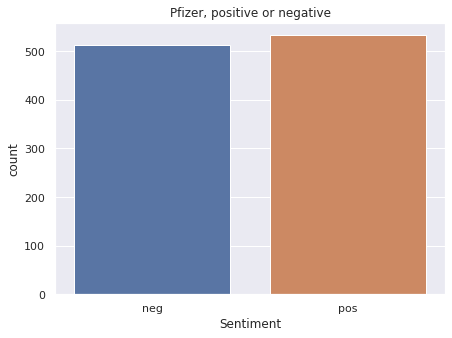

In [ ]:
# Create a DataFrame for Pfizer
Pfizer = df_original.loc[(df_original.text.str.contains('Pfizer')) | (df_original.text.str.contains('فايزر'))]
plt.figure(figsize=(7,5))
sns.set_theme(style="darkgrid")
ax = sns.countplot(x="new_sent", data=Pfizer).set_title("Pfizer, positive or negative")
plt.xlabel('Sentiment')
plt.show()

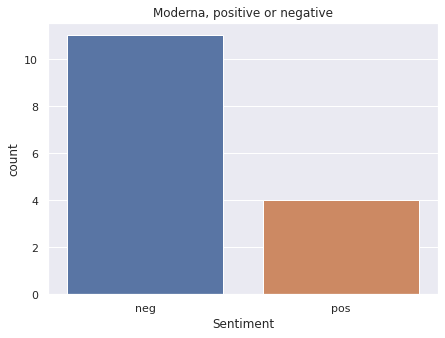

In [ ]:
# Create a DataFrame for Moderna مودرنا
#  اللقاح الروسي سبوتنيك spoutnik
Moderna =  df_original.loc[(df_original.text.str.contains('Moderna')) | (df_original.text.str.contains('مودرنا'))]
plt.figure(figsize=(7,5))
sns.set_theme(style="darkgrid")
ax = sns.countplot(x="new_sent", data=Moderna).set_title("Moderna, positive or negative")
plt.xlabel('Sentiment')
plt.show()

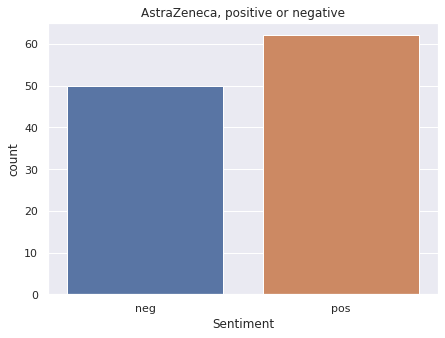

In [ ]:
# Create a DataFrame for AstraZeneca أسترازينيكا
AstraZeneca = df_original.loc[(df_original.text.str.contains('AstraZeneca')) | (df_original.text.str.contains('أسترازينيكا'))| (df_original.text.str.contains('الاسترازينكا'))] #الاسترازينكا
plt.figure(figsize=(7,5))
sns.set_theme(style="darkgrid")
ax = sns.countplot(x="new_sent", data=AstraZeneca).set_title("AstraZeneca, positive or negative")
plt.xlabel('Sentiment')
plt.show()

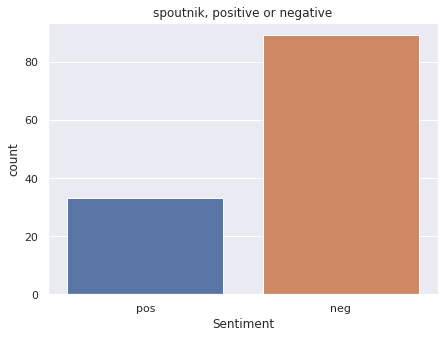

In [ ]:
# Create a DataFrame for Moderna
#  اللقاح الروسي سبوتنيك spoutnik
spo = ['سبوتنيك','الروسي','spoutnik']

#spoutnik = df_original[df_original.text.str.contains('سبوتنيك')]
spoutnik = df_original.loc[(df_original.text.str.contains('سبوتنيك')) | (df_original.text.str.contains('اللقاح الروسي')) | (df_original.text.str.contains('spoutnik'))]

plt.figure(figsize=(7,5))
sns.set_theme(style="darkgrid")
ax = sns.countplot(x="new_sent", data=spoutnik).set_title("spoutnik, positive or negative")
plt.xlabel('Sentiment')
plt.show()

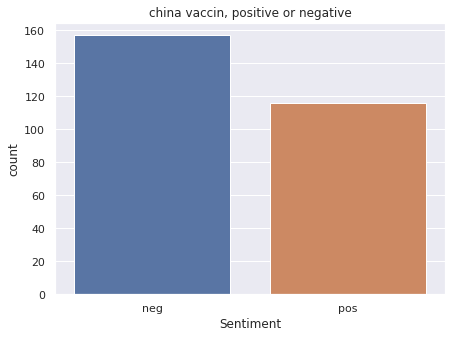

In [ ]:
# اللقاح الصيني سينوفارم Sinopharm 
# سينوفاك Sinovac 

china = df_original.loc[(df_original.text.str.contains('سينوفارم')) | (df_original.text.str.contains('سينوفاك')) | (df_original.text.str.contains('اللقاح الصيني'))| (df_original.text.str.contains('Sinovac')) | (df_original.text.str.contains('Sinopharm'))]

plt.figure(figsize=(7,5))
sns.set_theme(style="darkgrid")
ax = sns.countplot(x="new_sent", data=china).set_title("china vaccin, positive or negative")
plt.xlabel('Sentiment')
plt.show()

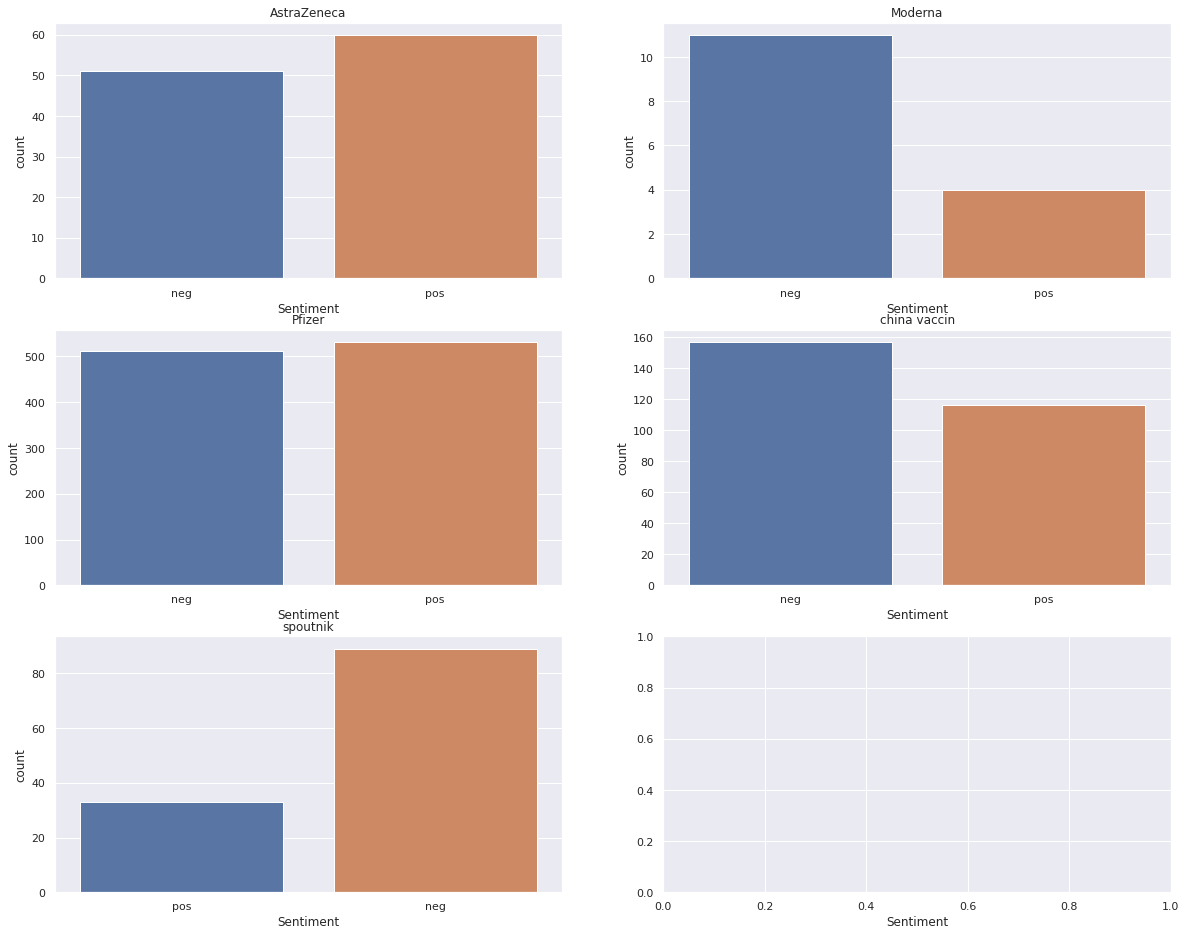

In [ ]:
fig, axs = plt.subplots(3,2,figsize=(20,16))
sns.countplot(x="new_sent", data=AstraZeneca, ax=axs[0,0]).set_title("AstraZeneca")
plt.xlabel('Sentiment')
sns.countplot(x="new_sent", data=Moderna, ax=axs[0,1]).set_title("Moderna")
plt.xlabel('Sentiment')
sns.countplot(x="new_sent", data=Pfizer, ax=axs[1,0]).set_title("Pfizer")
#plt.xlabel('Sentiment')
sns.countplot(x="new_sent", data=china, ax=axs[1,1]).set_title("china vaccin")
sns.countplot(x="new_sent", data=spoutnik, ax=axs[2,0]).set_title("spoutnik")

plt.setp(axs[0:], xlabel='Sentiment')
#plt.setp(axs[:, 0], ylabel='y axis label')
plt.show()

In [ ]:
# أمريكا  في امريكا
# فرنسا إتحاد الاوروبي بريطانيا اوربيه اتحاد اوروبي روسيا
# كويت سعودية بحرين امارات قطر عمان عراق جزائر لبنان تونس مغرب مصر

### chhina abrab countries

In [ ]:
arab = ['كويت', 'سعودية', 'بحرين', 'امارات', 'قطر', 'عمان', 'عراق', 'جزائر', 'لبنان', 'تونس', 'مغرب', 'مصر']
for w in arab:
  A = china.loc[(china.text.str.contains(w))]

In [ ]:
A.head()

,tweetDate,handle,text,profileUrl,name,tweetLink,tidy_tweet,subjectivity,polarity,Sentiment,new_sent
659,Fri Apr 02 19:41:58 +0000 2021,abdellwahabnegm,الحمدلله اخذت اليوم اللقاح الصيني وكنت تقدمت ا...,https://twitter.com/abdellwahabnegm,Abdel Wahab,https://twitter.com/abdellwahabnegm/status/137...,حمدلله اخذت اليوم لقاح صيني وكنت تقدمت جرعة ثا...,0.0,0.0,neutral,pos
4748,Fri Mar 26 21:49:45 +0000 2021,45mogaber,درس مستفاد للعقلاء👇\n- اخو زوجتي طبيب بألمانيا...,https://twitter.com/45mogaber,Mohamed,https://twitter.com/45mogaber/status/137556566...,مستفاد عقلاء زوجتي طبيب بألمانيا امتنع لقاح وق...,0.0,0.0,neutral,neg
26182,Fri Feb 19 22:17:45 +0000 2021,TfayliAbbass,#اللقاح_الصيني كمان و كمان\n\nاللقاح الصيني يس...,https://twitter.com/TfayliAbbass,AToufayli,https://twitter.com/TfayliAbbass/status/136288...,لقاح_الصيني كمان كمان لقاح صيني يستخدم امارات ...,0.0,0.0,neutral,neg
27538,Wed Jan 27 16:58:48 +0000 2021,Molmm81,@AssalaLamaa @TfayliAbbass الامارات نشرت و هي ...,https://twitter.com/Molmm81,🇱🇧🇦🇪🇸🇦 موكا لوكا,https://twitter.com/Molmm81/status/13544739453...,امارات نشرت مولوا ابحاثه، شريك سينوفارم اخذت ح...,0.0,0.0,neutral,neg
27678,Sat Jan 23 17:26:48 +0000 2021,Egypct,@youm7 والله أخذت اللقاح الصيني سينوفارم هنا ف...,https://twitter.com/Egypct,أحمد جاد 🇪🇬,https://twitter.com/Egypct/status/135303144293...,والله اخذت لقاح صيني سينوفارم امور تمام حمد ،ز...,0.0,0.0,neutral,pos


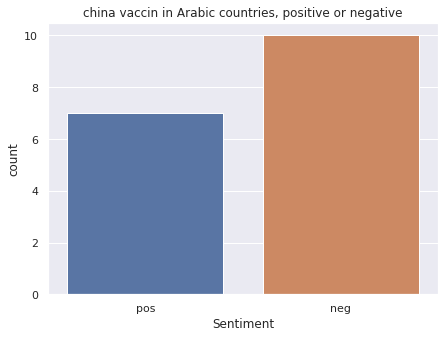

In [ ]:
plt.figure(figsize=(7,5))
sns.set_theme(style="darkgrid")
ax = sns.countplot(x="new_sent", data=A).set_title("china vaccin in Arabic countries, positive or negative")
plt.xlabel('Sentiment')
plt.show()

### china europe countries

In [ ]:
europ = ['فرنسا', 'إتحاد الاوروبي' ,'بريطانيا' ,'اوربيه' ,'اتحاد اوروبي', 'روسيا']
for w in europ:
  E = china.loc[(china.text.str.contains(w))]

In [ ]:
E.head()

,tweetDate,handle,text,profileUrl,name,tweetLink,tidy_tweet,subjectivity,polarity,Sentiment,new_sent
1406,Thu Apr 01 17:07:02 +0000 2021,Omani_Kin6F,@AlrajhiSalima بنيتي فشلها على هذا ؟!😂😂\nالإما...,https://twitter.com/Omani_Kin6F,الزِّنَاد العُماني,https://twitter.com/Omani_Kin6F/status/1377668...,بنيتي فشلها ؟! امارات اخذت لقاح صيني اصابات في...,0.0,0.0,neutral,neg
3903,Sun Mar 28 15:49:32 +0000 2021,rashed_saidi7,ارتفاع نسبة توزيع اللقاح في دولتي #الإمارات و ...,https://twitter.com/rashed_saidi7,راشِـــــدْ | 𝕽𝖆𝖘𝖍𝖎𝖉,https://twitter.com/rashed_saidi7/status/13761...,ارتفاع نسبة توزيع لقاح دولتي امارات بحرين سببه...,0.0,0.0,neutral,neg
11909,Mon Mar 15 17:20:10 +0000 2021,s_alfarhan1,، والحل: هو اعطاء لقاح مثل الروسي الذي اخذت من...,https://twitter.com/s_alfarhan1,سعود الفرحان,https://twitter.com/s_alfarhan1/status/1371511...,حل: اعطاء لقاح روسي الذي اخذت دول اوربيه يعقل ...,0.0,0.0,neutral,neg
23566,Thu Mar 04 11:35:30 +0000 2021,s_alfarhan1,والحل: هو اعطاء لقاح مثل الروسي الذي اخذت منه ...,https://twitter.com/s_alfarhan1,سعود الفرحان,https://twitter.com/s_alfarhan1/status/1367438...,حل: اعطاء لقاح روسي الذي اخذت دول اوربيه يعقل ...,0.0,0.0,neutral,neg
27159,Wed Feb 03 02:39:00 +0000 2021,i_kk10,📌فوق هذا كله انهم بايعين قضية مسلمين #مينامار ...,https://twitter.com/i_kk10,Khalid . a . shelwan 🇸🇦,https://twitter.com/i_kk10/status/135679428553...,فوق انهم بايعين قضية مسلمين مينامار انهم باعو ...,0.0,0.0,neutral,neg


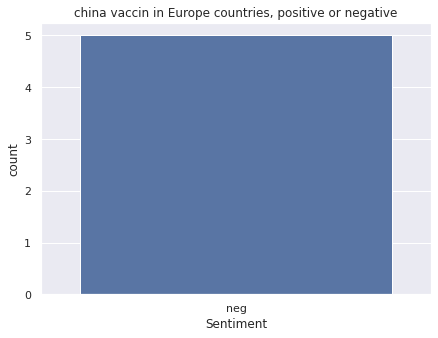

In [ ]:
plt.figure(figsize=(7,5))
sns.set_theme(style="darkgrid")
ax = sns.countplot(x="new_sent", data=E).set_title("china vaccin in Europe countries, positive or negative")
plt.xlabel('Sentiment')
plt.show()

### china usa countries




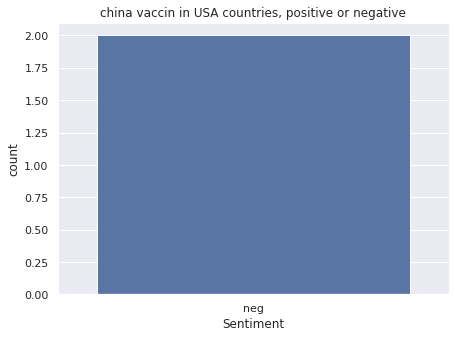

In [ ]:
USA = china.loc[(china.text.str.contains('أمريكا')) | (df_original.text.str.contains('في امريكا'))]
plt.figure(figsize=(7,5))
sns.set_theme(style="darkgrid")
ax = sns.countplot(x="new_sent", data=USA).set_title("china vaccin in USA countries, positive or negative")
plt.xlabel('Sentiment')
plt.show()

### china all in one

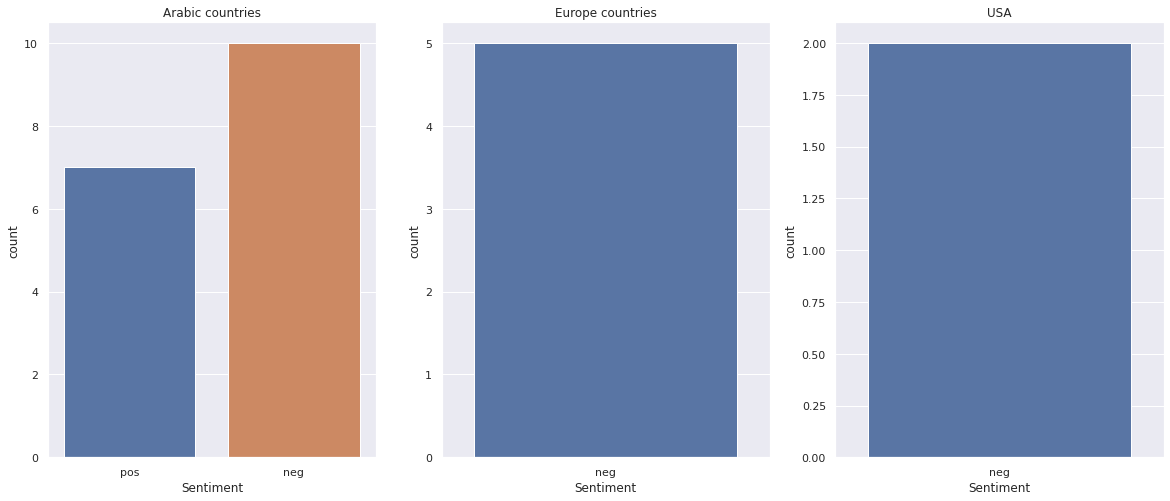

In [ ]:
fig, axs = plt.subplots(1,3,figsize=(20,8))
sns.countplot(x="new_sent", data=A, ax=axs[0]).set_title("Arabic countries")
plt.xlabel('Sentiment')
sns.countplot(x="new_sent", data=E, ax=axs[1]).set_title("Europe countries")
plt.xlabel('Sentiment')
sns.countplot(x="new_sent", data=USA, ax=axs[2]).set_title("USA")
#plt.xlabel('Sentiment')


plt.setp(axs[0:], xlabel='Sentiment')
#plt.setp(axs[:, 0], ylabel='y axis label')
plt.show()

### spoutnik arab countries

In [ ]:
arab = ['كويت', 'سعودية', 'بحرين', 'امارات', 'قطر', 'عمان', 'عراق', 'جزائر', 'لبنان', 'تونس', 'مغرب', 'مصر']
for w in arab:
  A = spoutnik.loc[(spoutnik.text.str.contains(w))]

In [ ]:
A.head()

,tweetDate,handle,text,profileUrl,name,tweetLink,tidy_tweet,subjectivity,polarity,Sentiment,new_sent
33155,Tue Aug 11 12:14:59 +0000 2020,drissawaked,بوتين يعلن عن تسجيل أول لقاح ضد فيروس كورونا ف...,https://twitter.com/drissawaked,د. عيسى عباس واكد,https://twitter.com/drissawaked/status/1293158...,بوتين يعلن تسجيل لقاح فيروس كورونا عالم. بوتين...,0.0,0.0,neutral,neg
33223,Tue Aug 11 12:38:35 +0000 2020,drissawaked,@SaudiMOH بوتين يعلن عن تسجيل أول لقاح ضد فيرو...,https://twitter.com/drissawaked,د. عيسى عباس واكد,https://twitter.com/drissawaked/status/1293164...,بوتين يعلن تسجيل لقاح فيروس كورونا عالم. بوتين...,0.0,0.0,neutral,neg


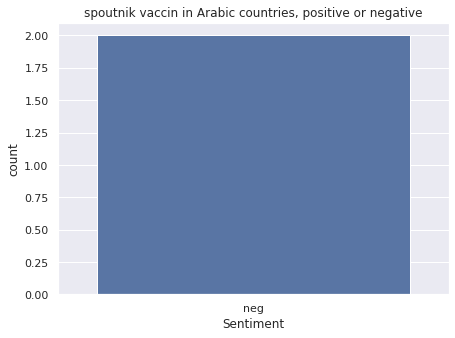

In [ ]:
plt.figure(figsize=(7,5))
sns.set_theme(style="darkgrid")
ax = sns.countplot(x="new_sent", data=A).set_title("spoutnik vaccin in Arabic countries, positive or negative")
plt.xlabel('Sentiment')
plt.show()

### spoutnik europe countries

In [ ]:
europ = ['فرنسا', 'إتحاد الاوروبي' ,'بريطانيا' ,'اوربيه' ,'اتحاد اوروبي', 'روسيا']
for w in europ:
  E = spoutnik.loc[(spoutnik.text.str.contains(w))]
E.head()

,tweetDate,handle,text,profileUrl,name,tweetLink,tidy_tweet,subjectivity,polarity,Sentiment,new_sent
1406,Thu Apr 01 17:07:02 +0000 2021,Omani_Kin6F,@AlrajhiSalima بنيتي فشلها على هذا ؟!😂😂\nالإما...,https://twitter.com/Omani_Kin6F,الزِّنَاد العُماني,https://twitter.com/Omani_Kin6F/status/1377668...,بنيتي فشلها ؟! امارات اخذت لقاح صيني اصابات في...,0.0,0.0,neutral,neg
27053,Fri Feb 05 15:35:28 +0000 2021,ala2017lwe,@rrroos20301 @a_1k2 اخذت منة قبل ايام \nتنتظر ...,https://twitter.com/ala2017lwe,هادي🇸🇦,https://twitter.com/ala2017lwe/status/13577144...,اخذت ايام تنتظر دفعة جديدة كذلك لقاح روسي ممتا...,0.0,0.0,neutral,pos
27164,Tue Feb 02 15:17:51 +0000 2021,sdng1950,@Vidoco2018 صحيح وخاصة أن الطفرات الجديدةمعدية...,https://twitter.com/sdng1950,DrSaeed الشمس أجمل في بلادي... حتى الظلام،السياب,https://twitter.com/sdng1950/status/1356622869...,صحيح وخاصة طفرات جديدةمعدية جدآ. ساعة نشرت خلا...,0.0,0.0,neutral,neg
27258,Tue Feb 02 15:23:23 +0000 2021,sdng1950,الطفرات الجديدة لكوفيد19معدية جدآ. قبل ساعة نش...,https://twitter.com/sdng1950,DrSaeed الشمس أجمل في بلادي... حتى الظلام،السياب,https://twitter.com/sdng1950/status/1356624259...,طفرات جديدة لكوفيد19معدية جدآ. ساعة نشرت خلاصة...,0.0,0.0,neutral,neg
27437,Fri Jan 29 09:31:56 +0000 2021,OsamaAlhamad_RT,اليوم أخذت الجرعة الأولى من اللقاح الذي وفرته ...,https://twitter.com/OsamaAlhamad_RT,أسامة الحمد,https://twitter.com/OsamaAlhamad_RT/status/135...,اليوم اخذت جرعة اولى لقاح الذي وفرته قناة لنا....,0.0,0.0,neutral,pos


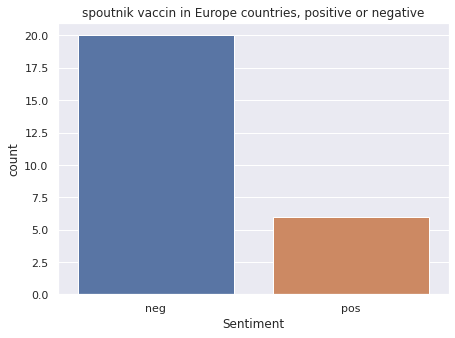

In [ ]:
plt.figure(figsize=(7,5))
sns.set_theme(style="darkgrid")
ax = sns.countplot(x="new_sent", data=E).set_title("spoutnik vaccin in Europe countries, positive or negative")
plt.xlabel('Sentiment')
plt.show()

### spoutnik usa countries EMPTY

In [ ]:
USA = spoutnik.loc[(spoutnik.text.str.contains('أمريكا')) | (df_original.text.str.contains('في امريكا'))]
USA # Empty

,tweetDate,handle,text,profileUrl,name,tweetLink,tidy_tweet,subjectivity,polarity,Sentiment,new_sent


### Spoutnik all in one

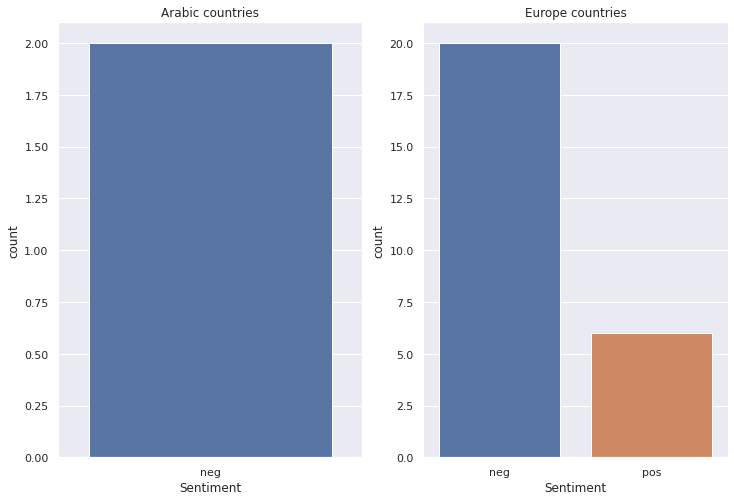

In [ ]:
fig, axs = plt.subplots(1,2,figsize=(12,8))
sns.countplot(x="new_sent", data=A, ax=axs[0]).set_title("Arabic countries")
plt.xlabel('Sentiment')
sns.countplot(x="new_sent", data=E, ax=axs[1]).set_title("Europe countries")
plt.xlabel('Sentiment')
#sns.countplot(x="new_sent", data=USA, ax=axs[2]).set_title("USA")
#plt.xlabel('Sentiment')


plt.setp(axs[0:], xlabel='Sentiment')
#plt.setp(axs[:, 0], ylabel='y axis label')
plt.show()

### Moderna in arabic countries

In [ ]:
arab = ['كويت', 'سعودية', 'بحرين', 'امارات', 'قطر', 'عمان', 'عراق', 'جزائر', 'لبنان', 'تونس', 'مغرب', 'مصر']
for w in arab:
  A = Moderna.loc[(Moderna.text.str.contains(w))]
A  # Empty

,tweetDate,handle,text,profileUrl,name,tweetLink,tidy_tweet,subjectivity,polarity,Sentiment,new_sent


### Moderna in europe countries

In [ ]:
europ = ['فرنسا', 'إتحاد الاوروبي' ,'بريطانيا' ,'اوربيه' ,'اتحاد اوروبي', 'روسيا']
for w in europ:
  E = Moderna.loc[(Moderna.text.str.contains(w))]
E   # Empty

,tweetDate,handle,text,profileUrl,name,tweetLink,tidy_tweet,subjectivity,polarity,Sentiment,new_sent


### Moderna in usa

In [ ]:
USA = Moderna.loc[(Moderna.text.str.contains('أمريكا')) | (df_original.text.str.contains('في امريكا'))]
USA # Empty

,tweetDate,handle,text,profileUrl,name,tweetLink,tidy_tweet,subjectivity,polarity,Sentiment,new_sent


### Pfizer in arabic countries

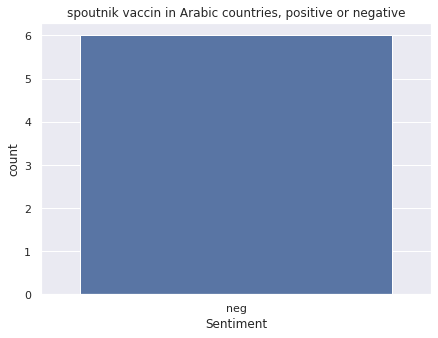

In [ ]:
arab = ['كويت', 'سعودية', 'بحرين', 'امارات', 'قطر', 'عمان', 'عراق', 'جزائر', 'لبنان', 'تونس', 'مغرب', 'مصر']
for w in arab:
  A = Pfizer.loc[(Pfizer.text.str.contains(w))]
plt.figure(figsize=(7,5))
sns.set_theme(style="darkgrid")
ax = sns.countplot(x="new_sent", data=A).set_title("Pfizer vaccin in Arabic countries, positive or negative")
plt.xlabel('Sentiment')
plt.show()

### Pfizer in Europe countries



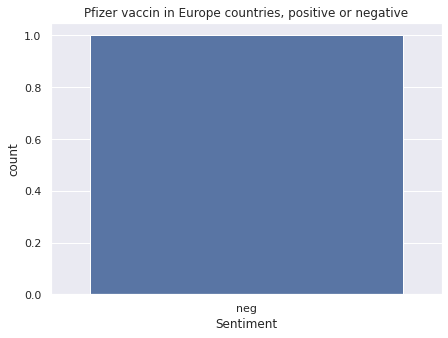

In [ ]:
europ = ['فرنسا', 'إتحاد الاوروبي' ,'بريطانيا' ,'اوربيه' ,'اتحاد اوروبي', 'روسيا']
for w in europ:
  E = Pfizer.loc[(Pfizer.text.str.contains(w))]
plt.figure(figsize=(7,5))
sns.set_theme(style="darkgrid")
ax = sns.countplot(x="new_sent", data=E).set_title("Pfizer vaccin in Europe countries, positive or negative")
plt.xlabel('Sentiment')
plt.show()

### Pfizer in usa

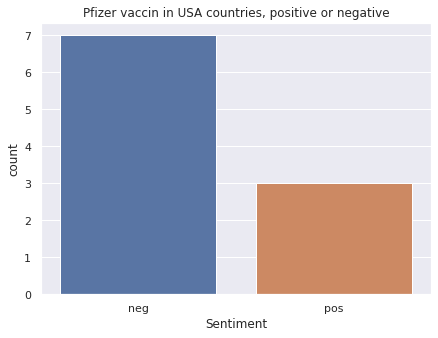

In [ ]:
USA = Pfizer.loc[(Pfizer.text.str.contains('أمريكا')) | (df_original.text.str.contains('في امريكا'))]
plt.figure(figsize=(7,5))
sns.set_theme(style="darkgrid")
ax = sns.countplot(x="new_sent", data=USA).set_title("Pfizer vaccin in USA countries, positive or negative")
plt.xlabel('Sentiment')
plt.show()

### Pfizer all in one

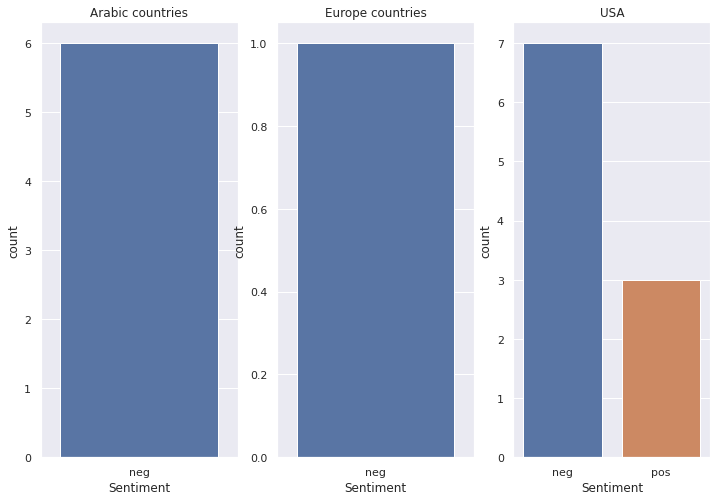

In [ ]:
fig, axs = plt.subplots(1,3,figsize=(12,8))
sns.countplot(x="new_sent", data=A, ax=axs[0]).set_title("Arabic countries")
plt.xlabel('Sentiment')
sns.countplot(x="new_sent", data=E, ax=axs[1]).set_title("Europe countries")
plt.xlabel('Sentiment')
sns.countplot(x="new_sent", data=USA, ax=axs[2]).set_title("USA")
#plt.xlabel('Sentiment')


plt.setp(axs[0:], xlabel='Sentiment')
#plt.setp(axs[:, 0], ylabel='y axis label')
plt.show()

### AstraZeneca in arabic countries

In [ ]:
arab = ['كويت', 'سعودية', 'بحرين', 'امارات', 'قطر', 'عمان', 'عراق', 'جزائر', 'لبنان', 'تونس', 'مغرب', 'مصر']
for w in arab:
  A = AstraZeneca.loc[(AstraZeneca.text.str.contains(w))]
A  # Empty

,tweetDate,handle,text,profileUrl,name,tweetLink,tidy_tweet,subjectivity,polarity,Sentiment,new_sent


### AstraZeneca in europe countries

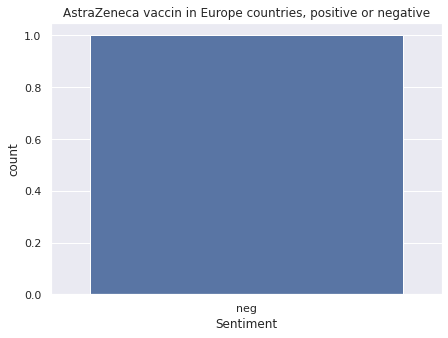

In [ ]:
europ = ['فرنسا', 'إتحاد الاوروبي' ,'بريطانيا' ,'اوربيه' ,'اتحاد اوروبي', 'روسيا']
for w in europ:
  E = AstraZeneca.loc[(AstraZeneca.text.str.contains(w))]
plt.figure(figsize=(7,5))
sns.set_theme(style="darkgrid")
ax = sns.countplot(x="new_sent", data=E).set_title("AstraZeneca vaccin in Europe countries, positive or negative")
plt.xlabel('Sentiment')
plt.show()

### AstraZeneca in usa

In [ ]:
USA = AstraZeneca.loc[(AstraZeneca.text.str.contains('أمريكا')) | (df_original.text.str.contains('في امريكا'))]
USA # Empty

,tweetDate,handle,text,profileUrl,name,tweetLink,tidy_tweet,subjectivity,polarity,Sentiment,new_sent


# Question (3

### All region

In [ ]:
#effect = df_original.loc[(df_original.text.str.contains('اعراض')), 'tidy_tweet']
effect = ' '.join([text.replace('حراره','حرارة') for text in df_original.loc[(df_original.text.str.contains('اعراض')), 'tidy_tweet']])
freq = pd.Series(effect.split()).value_counts()[:50]

In [ ]:
freq

لقاح       2455
اعراض      1855
اخذت       1808
حمد         448
الله        417
حمدلله      364
اولى        254
جرعة        251
اليوم       230
حرارة       204
جرعه        195
اللي        190
كورونا      185
ولله        181
صداع        150
فايزر       130
مكان        124
ايام        123
يومين       121
ثانيه       115
جانبية      109
ثاني        107
ساعه        107
ساعات        95
ساعة         91
ثانية        91
جسم          90
خفيف         89
طبيعي        89
حين          86
الان         86
عندي         86
جميع         85
بدون         84
اكسفورد      83
خمول         81
ناس          80
ابره         78
والله        77
وانا         76
خفيفه        75
حسيت         72
والم         72
تقريبا       70
امور         70
كانت         70
بسيط         68
اسبوع        68
بنادول       67
جانبيه       67
dtype: int64

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 65010 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:183: RuntimeWarning: Glyph 65010 missing from current font.
  font.set_text(s, 0, flags=flags)


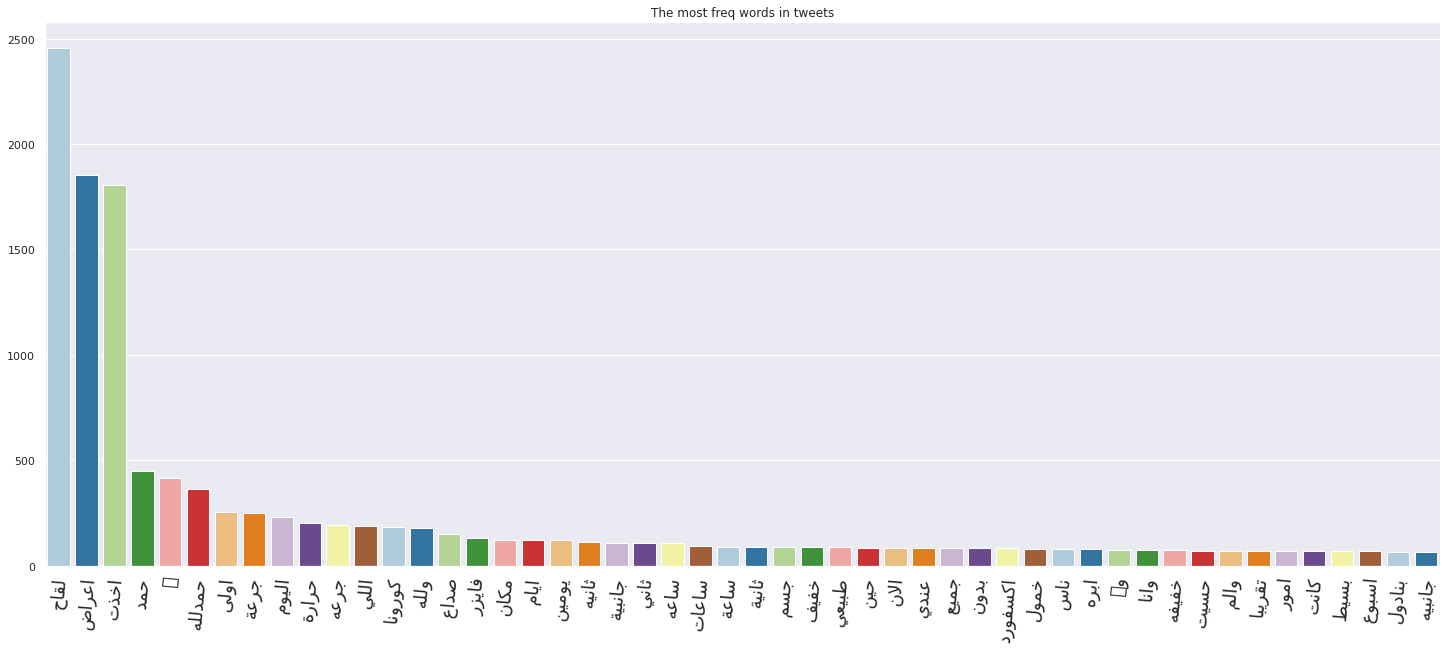

In [ ]:
import arabic_reshaper
combind = ' '.join(freq.index)
#combind
data = arabic_reshaper.reshape(combind)
data = get_display(data)
data = data.split()
data.reverse()
#print(data)
fig, ax = plt.subplots(figsize=(25,10))
ax = sns.barplot(data, freq.values, palette="Paired")


for tick in ax.xaxis.get_major_ticks():
                tick.label.set_fontsize(18)
                tick.label.set_rotation(85)
plt.savefig('term_frequency_all_data.png')
plt.title('The most freq words in tweets')
plt.show()

In [ ]:
freq = pd.Series(effect.split()).value_counts()
words = [ 'حرارة' ,  'صداع','عضلات','تعبت', 'سخونة','الم', 'نوم','تعب','ارهاق' ,'الدم', 'تنام', 'رجفة' ,'كحة'] 
ef = pd.Series()
for i in words:
  ef[i] = freq[i]
ef.sort_values(ascending=True)
ef

حرارة    204
صداع     150
عضلات     30
تعبت      27
سخونة     27
الم       23
نوم       14
تعب       14
ارهاق     12
الدم       5
تنام       3
رجفة       3
كحة        1
dtype: int64

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


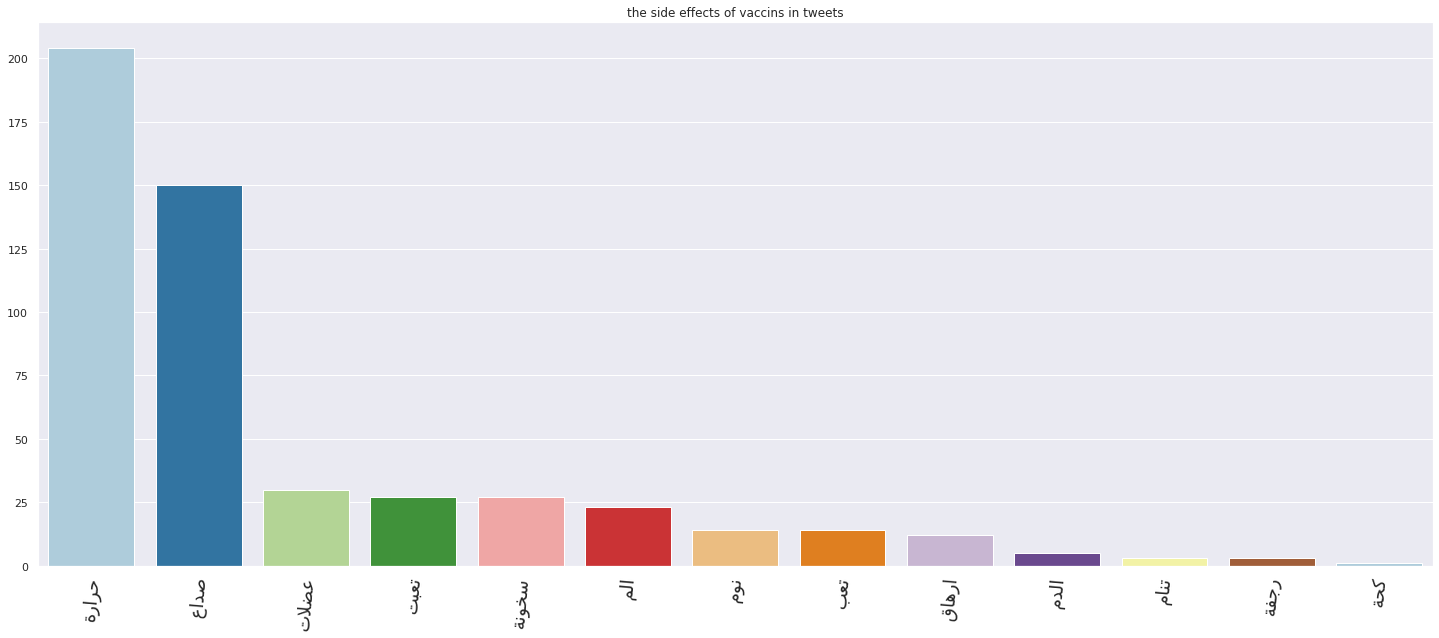

In [ ]:
import arabic_reshaper
combind = ' '.join(ef.index)
#combind
data = arabic_reshaper.reshape(combind)
data = get_display(data)
data = data.split()
data.reverse()
#print(data)
fig, ax = plt.subplots(figsize=(25,10))
ax = sns.barplot(data, ef.values, palette="Paired")


for tick in ax.xaxis.get_major_ticks():
                tick.label.set_fontsize(18)
                tick.label.set_rotation(85)
plt.savefig('term_frequency_all_data.png')
plt.title('the side effects of vaccins in tweets')
plt.show()

### Arab

In [ ]:
arab = ['كويت', 'سعودية', 'بحرين', 'امارات', 'قطر', 'عمان', 'عراق', 'جزائر', 'لبنان', 'تونس', 'مغرب', 'مصر'] # اثار
for w in arab:
  A = df_original.loc[(df_original.text.str.contains(w))]
effect = ' '.join([text.replace('حراره','حرارة') for text in A.loc[(A.text.str.contains('اعراض')) , 'tidy_tweet']])
#effect = effect.join([text.replace('حراره','حرارة') for text in A.loc[(A.text.str.contains('اثار')) , 'tidy_tweet']])

freq = pd.Series(effect.split()).value_counts()


/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


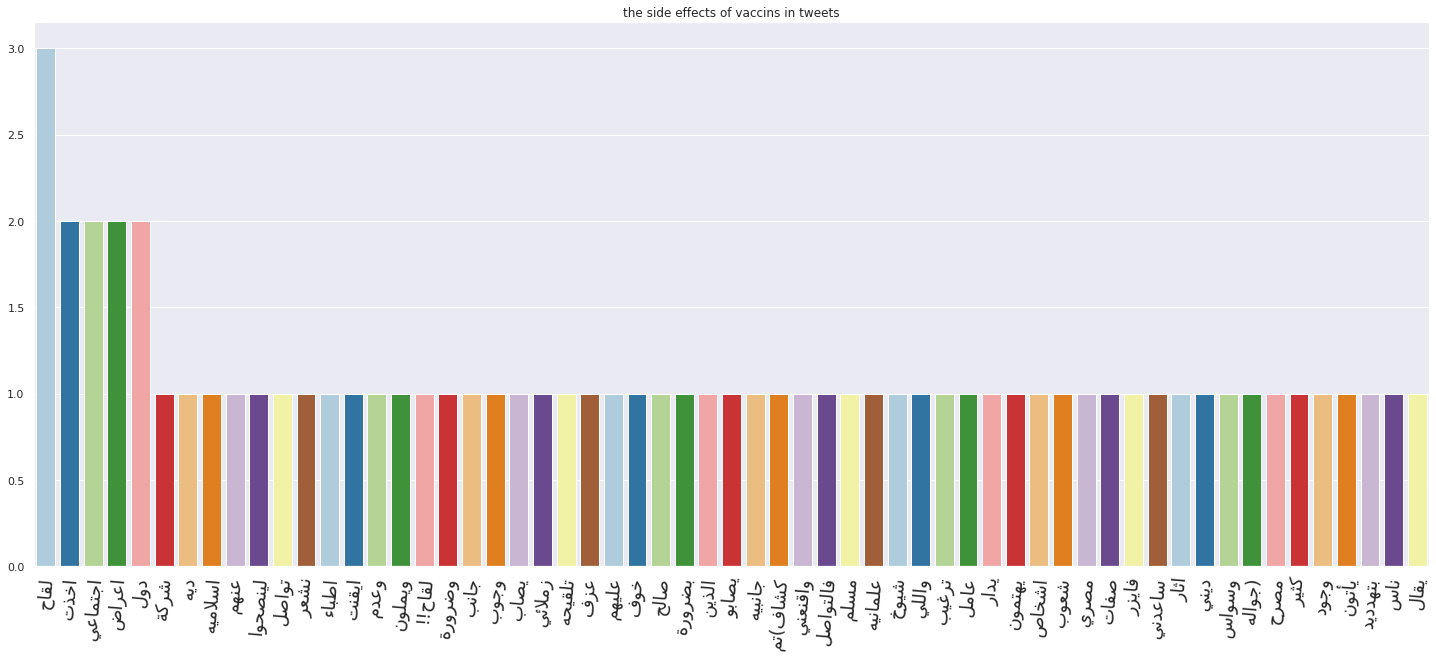

In [ ]:
import arabic_reshaper
combind = ' '.join(freq.index)
#combind
data = arabic_reshaper.reshape(combind)
data = get_display(data)
data = data.split()
data.reverse()
#print(data)
fig, ax = plt.subplots(figsize=(25,10))
ax = sns.barplot(data, freq.values, palette="Paired")


for tick in ax.xaxis.get_major_ticks():
                tick.label.set_fontsize(18)
                tick.label.set_rotation(85)
plt.savefig('term_frequency_all_data.png')
plt.title('the side effects of vaccins in tweets')
plt.show()

In [ ]:
A

,tweetDate,handle,text,profileUrl,name,tweetLink,tidy_tweet,subjectivity,polarity,Sentiment,new_sent
4,Sat Apr 03 21:53:02 +0000 2021,afrah_bintsaif,@shaimarezk @Mohd_AlRais انا في مصر حاليا وال...,https://twitter.com/afrah_bintsaif,Afrah bint saif🇦🇪,https://twitter.com/afrah_bintsaif/status/1378...,حاليا مفروض اخذت لقاح عرفت عوده هناك عشره ايام...,0.0,0.0,neutral,neg
34,Sat Apr 03 19:48:06 +0000 2021,hazemyounes31,@SaudiMOH937 \nاخذت اللقاح اليوم وبعدها هنزل م...,https://twitter.com/hazemyounes31,hazem younes,https://twitter.com/hazemyounes31/status/13784...,اخذت لقاح اليوم وبعدها هنزل اجازه شهور موقفي ج...,0.0,0.0,neutral,neg
659,Fri Apr 02 19:41:58 +0000 2021,abdellwahabnegm,الحمدلله اخذت اليوم اللقاح الصيني وكنت تقدمت ا...,https://twitter.com/abdellwahabnegm,Abdel Wahab,https://twitter.com/abdellwahabnegm/status/137...,حمدلله اخذت اليوم لقاح صيني وكنت تقدمت جرعة ثا...,0.0,0.0,neutral,pos
683,Fri Apr 02 19:49:29 +0000 2021,iiivb6,اليوم كنت ف المطعم المصري ف الردسي جاني واحد ي...,https://twitter.com/iiivb6,Hasan,https://twitter.com/iiivb6/status/137807211168...,اليوم مطعم مصري ردسي جاني واحد يشتغل سعودي اخذ...,0.0,0.0,neutral,neg
1032,Fri Apr 02 11:48:31 +0000 2021,HossamE51700681,@SaudiMOH937 اخذت الجرعة الأولى من اللقاح و مو...,https://twitter.com/HossamE51700681,Hossam EL-Hawary,https://twitter.com/HossamE51700681/status/137...,اخذت جرعة اولى لقاح موعد جرعة ثانية نهاية شوال...,0.0,0.0,neutral,pos
...,...,...,...,...,...,...,...,...,...,...,...
33580,Fri Apr 02 19:29:21 +0000 2021,Albir48384909,الاستاذ ابراهيم عيسى برجاء سيادتك الكف عن القو...,https://twitter.com/Albir48384909,Albir,https://twitter.com/Albir48384909/status/13780...,استاذ ابراهيم عيسى برجاء سيادتك الكف قول مصريي...,0.0,0.0,neutral,pos
33608,Tue Mar 30 22:51:04 +0000 2021,ammaralihassan,تلقيت أمس لقاح سينوفارم ضد كورونا مجانا. كنت م...,https://twitter.com/ammaralihassan,عمار علي حسن Ammar Ali Hassan,https://twitter.com/ammaralihassan/status/1377...,تلقيت لقاح سينوفارم كورونا مجانا. متشككا بداية...,0.0,0.0,neutral,pos
33674,Tue Mar 23 22:40:34 +0000 2021,ayman_sorour,#مصطفى_الفقي ل @Sherif_Amer_ في @YahdothFiMasr...,https://twitter.com/ayman_sorour,Ayman Sorour,https://twitter.com/ayman_sorour/status/137449...,مصطفى فقي تلقيت لقاح كورونا تصريح يطرح سؤال سا...,0.0,0.0,neutral,pos
33695,Tue Mar 23 15:31:54 +0000 2021,essam1965,عاجل\nلقد أصبت بكورونا مع اننى تلقيت اللقاح من...,https://twitter.com/essam1965,mohamed essam hassan,https://twitter.com/essam1965/status/137438341...,عاجل اصبت بكورونا اننى تلقيت لقاح فايزر امريكى...,0.0,0.0,neutral,neg


In [ ]:
freq = pd.Series(effect.split()).value_counts()
ef = pd.Series()
for i in words:
  ef[i] = freq[i]
ef.sort_values(ascending=True)
ef # EMPTY

### Europe

In [ ]:
USA = df_original.loc[(df_original.text.str.contains('أمريكا')) | (df_original.text.str.contains('في امريكا'))]
for w in europ:
  A = USA.loc[(df_original.text.str.contains(w))]
effect = ' '.join([text.replace('حراره','حرارة') for text in A.loc[(A.text.str.contains('اعراض')) , 'tidy_tweet']])
#effect = effect.join([text.replace('حراره','حرارة') for text in A.loc[(A.text.str.contains('اثار')) , 'tidy_tweet']])

freq = pd.Series(effect.split()).value_counts()

In [ ]:
words = [ 'صداع','عضلات','تعبت', 'سخونة','الم', 'نوم','تعب','ارهاق' ,'الدم', 'تنام', 'رجفة' ,'كحة'] 


In [ ]:

freq = pd.Series(effect.split()).value_counts()
ef = pd.Series()
for i in words:
  ef[i] = freq[i]
ef.sort_values(ascending=True)
ef # EMPTY

KeyError: ignored